# Data analysis and set up

In [1]:
# Prediction margin: the only paramter to set. Recommended: margin in {5, 10, 15, 20} (aka 0.5, 1, 1.5, 2 seconds)
margin = 20

## Import libraries and define utility functions

In [2]:
import pandas as pd
import numpy as np
import sys
import random
import pickle
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from math import floor

In [3]:
mean = lambda l: sum(l) / len(l)

def describe(l, n_quantiles=10, list_quantiles=None):
    print(f'Min={min(l):.4}, Max={max(l):.4}, Avg={mean(l):.4}, Tot={len(l)}')
    if list_quantiles is None:
        list_quantiles = [e / n_quantiles for e in range(1, n_quantiles)]
    for q in list_quantiles:
        print(q, ":", round(np.quantile(l, q), 3))
    return min(l), max(l), mean(l), len(l)

#### Set up global variables

In [4]:
pd.set_option('display.float_format', lambda x: '%.4f' % x)
plt.rcParams['figure.figsize'] = [18, 12]

#### Paths

In [5]:
f_headers = r'data/headers.txt'
f_acc = r'data/train-raw/dataset_acc.csv'
f_pos = r'data/train-raw/dataset_pos.csv'
f_labels = r'data/train-raw/labels.csv'

## Raw data import

In [6]:
with open(f_headers) as f_headers:
    col_acc = f_headers.readline()[:-1].split(",")
    col_pos = f_headers.readline()[:-1].split(",")
    col_lab = f_headers.readline().split(",")

In [7]:
acc_df = pd.read_csv(f_acc, names=col_acc)
pos_df = pd.read_csv(f_pos, names=col_pos)
lab_df = pd.read_csv(f_labels, names=col_lab)

#### Raw data inspection

In [8]:
print(f'The dataset contains {len(acc_df)} samples')
acc_df.head()

The dataset contains 48475 samples


,time_server,time_client,Gz,Ax,Ay
0,1652362636.7914,1651189909.1296,0.0992,13.0900,-10.1100
1,1652362636.8909,1651189909.2297,0.1069,13.5000,-10.6400
2,1652362636.9910,1651189909.3297,0.0687,13.6700,-10.7700
3,1652362637.0912,1651189909.4299,0.0916,13.4500,-10.9600
4,1652362637.2009,1651189909.5301,0.0611,13.5700,-10.7400


In [9]:
print(f'The dataset contains {len(pos_df)} samples')
pos_df.head()

The dataset contains 63659 samples


,time_server,POSx,POSy,orient
0,1652360970.6263,25.9792,24.8230,35.1435
1,1652360970.7392,25.9792,24.8230,35.1435
2,1652360970.8375,25.9792,24.8230,35.1435
3,1652360970.9379,25.9792,24.8230,35.1435
4,1652360971.0487,25.9792,24.8230,35.1435


In [10]:
print(f'The dataset contains {len(lab_df)} samples')
lab_df.head()

The dataset contains 56 samples


,time_server,label
0,1652362761.9701,s
1,1652362860.2747,f
2,1652362886.7204,s
3,1652363098.3831,f
4,1652363126.9348,s


## Data merge

In [11]:
def find_nearest(array, value, return_index=True):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    if return_index:
        return array[idx], idx
    else:
        return array[idx]

def merge_data(acc, pos, lab):
    
    delta = 0.05  # data sampling from sensors every 0.1s on average
    merged_data = []
    disalignments = []
    
    for i_lab in range(len(lab) - 1):
        if lab.loc[i_lab, "label"] == "s":
            start = lab.loc[i_lab, "time_server"]
            end = lab.loc[i_lab + 1, "time_server"]
            curr_acc = acc[(acc["time_server"] > start - delta) & (acc["time_server"] < end + delta)]
            curr_pos = pos[(pos["time_server"] > start - delta) & (pos["time_server"] < end + delta)]
            
            for i_acc in range(len(curr_acc)):
                curr_data_acc = curr_acc.iloc[i_acc]
                curr_time = curr_data_acc["time_server"]
                curr_data_acc = curr_data_acc.tolist()
                nearest, i_nearest = find_nearest(curr_pos["time_server"].to_numpy(), curr_time)
                disalignments.append(np.abs(curr_time - nearest))
                curr_data_pos = curr_pos.iloc[i_nearest].tolist()
                merged_data.append(curr_data_acc + curr_data_pos + [len(curr_acc) - 1 - i_acc])
                
            print(f'The {int(i_lab / 2 + 1)}° lap lasts for approx. {len(curr_acc) / 10} seconds')
        
    return merged_data, disalignments

In [12]:
merged_data, time_disalignments = merge_data(acc_df, pos_df, lab_df)

The 1° lap lasts for approx. 97.0 seconds
The 2° lap lasts for approx. 209.9 seconds
The 3° lap lasts for approx. 168.6 seconds
The 4° lap lasts for approx. 100.3 seconds
The 5° lap lasts for approx. 96.7 seconds
The 6° lap lasts for approx. 170.4 seconds
The 7° lap lasts for approx. 207.1 seconds
The 8° lap lasts for approx. 61.0 seconds
The 9° lap lasts for approx. 62.4 seconds
The 10° lap lasts for approx. 101.8 seconds
The 11° lap lasts for approx. 209.1 seconds
The 12° lap lasts for approx. 133.9 seconds
The 13° lap lasts for approx. 137.9 seconds
The 14° lap lasts for approx. 133.1 seconds
The 15° lap lasts for approx. 71.5 seconds
The 16° lap lasts for approx. 98.0 seconds
The 17° lap lasts for approx. 136.2 seconds
The 18° lap lasts for approx. 135.4 seconds
The 19° lap lasts for approx. 176.2 seconds
The 20° lap lasts for approx. 60.2 seconds
The 21° lap lasts for approx. 100.8 seconds
The 22° lap lasts for approx. 105.6 seconds
The 23° lap lasts for approx. 176.3 seconds
The 

In [13]:
raw_df = pd.DataFrame(merged_data, columns=col_acc+["time_server_pos"]+col_pos[1:]+["label"])
raw_df

,time_server,time_client,Gz,Ax,Ay,time_server_pos,POSx,POSy,orient,label
0,1652362761.9311,1651190034.2629,-0.4733,17.0700,-9.6920,1652362761.9288,31.4852,20.2254,-2.7575,969
1,1652362762.0311,1651190034.3632,-0.4656,17.3300,-14.8200,1652362762.0276,31.4837,20.2533,-3.1751,968
2,1652362762.1312,1651190034.4634,-0.5115,17.1900,-12.6500,1652362762.1255,31.4819,20.2835,-3.5885,967
3,1652362762.2310,1651190034.5637,-0.4580,14.1800,-8.8130,1652362762.2247,31.4798,20.3164,-4.0164,966
4,1652362762.3311,1651190034.6640,-0.4275,14.9900,-10.2100,1652362762.3241,31.4820,20.3500,-4.3625,965
...,...,...,...,...,...,...,...,...,...,...
33857,1652367586.1811,1651194858.5258,-1.3050,1.7820,-12.7000,1652367586.1404,30.8765,26.2029,-173.1982,4
33858,1652367586.2812,1651194858.6260,-1.2140,12.9600,-16.1900,1652367586.2417,30.8702,26.1001,-174.4489,3
33859,1652367586.3812,1651194858.7263,-0.8855,-8.0570,-10.6700,1652367586.3397,30.8622,26.0081,-175.6217,2
33860,1652367586.4810,1651194858.8266,-0.1221,-17.6500,-19.4300,1652367586.4401,30.8580,25.9483,-176.6935,1


## Data processing

In [14]:
useful_columns_raw = ["Gz", "Ax", "Ay", 'POSx', 'POSy', 'orient', "label"]

In [15]:
raw_df_reduced = raw_df[useful_columns_raw]

In [16]:
df_split = []
fault_indexes = raw_df_reduced.index[raw_df_reduced["label"] == 0].tolist() # list of indexes representing faults
        
previous = 0
for fi in fault_indexes:
    df_split.append(raw_df_reduced.iloc[previous:fi+1, :])
    previous = fi + 1

In [17]:
print(f'There are {len(df_split)} faults, hence {len(df_split)} datasets.')
for i, df_tmp in enumerate(df_split):
    print(i, df_tmp.shape)

There are 28 faults, hence 28 datasets.
0 (970, 7)
1 (2099, 7)
2 (1686, 7)
3 (1003, 7)
4 (967, 7)
5 (1704, 7)
6 (2071, 7)
7 (610, 7)
8 (624, 7)
9 (1018, 7)
10 (2091, 7)
11 (1339, 7)
12 (1379, 7)
13 (1331, 7)
14 (715, 7)
15 (980, 7)
16 (1362, 7)
17 (1354, 7)
18 (1762, 7)
19 (602, 7)
20 (1008, 7)
21 (1056, 7)
22 (1763, 7)
23 (605, 7)
24 (951, 7)
25 (428, 7)
26 (727, 7)
27 (1657, 7)


## Features creation

In [18]:
w_lens = [5, 10, 15, 20]

In [19]:
new_dfs = []
lag_features = []
first = True

for temps in df_split:
    curr_w_len_data = []
    for w_len in w_lens:

        means = temps.rolling(w_len).mean()
        cols = [t + "_mean_w" + str(w_len) for t in temps.columns]
        means.columns = cols 
        curr_w_len_data.append(means)
        if first:
            lag_features.append(cols)
        
        stds = temps.rolling(w_len).std()
        cols = [t + "_std_w" + str(w_len) for t in temps.columns]
        stds.columns = cols
        curr_w_len_data.append(stds)
        if first:
            lag_features.append(cols)

        mins = temps.rolling(w_len).min()
        cols = [t + "_min_w" + str(w_len) for t in temps.columns]
        mins.columns = cols
        curr_w_len_data.append(mins)
        if first:
            lag_features.append(cols)

        maxs = temps.rolling(w_len).max()
        cols = [t + "_max_w" + str(w_len) for t in temps.columns]
        maxs.columns = cols
        curr_w_len_data.append(maxs)
        if first:
            lag_features.append(cols)
    
    first = False

    temps_diff = temps - temps.shift(1)
    temps_diff.columns = [t + "_diff" for t in temps.columns]

    df_with_nan = pd.concat([temps, temps_diff] + curr_w_len_data, axis=1)
    df_curr = df_with_nan.dropna()

    new_dfs.append(df_curr)

df_new_features = new_dfs[0]
for to_concat in new_dfs[1:]:
    df_new_features = pd.concat([df_new_features, to_concat])
    
lag_features = [e for nested_lag_features in lag_features for e in nested_lag_features 
                if not e.startswith("POS") and not e.startswith("orient") and not e.startswith("label")]

In [20]:
point_features = ['Gz', 'Ax', 'Ay', 'Gz_diff', 
                  'Ax_diff', 'Ay_diff']
differencing_features = point_features + lag_features
new_features = differencing_features + ['POSx', 'POSy', 'orient', 'label']
df_new_features = df_new_features[new_features]
df_new_features = df_new_features.reset_index(drop=True)

In [21]:
df_new_features.head()

,Gz,Ax,Ay,Gz_diff,Ax_diff,Ay_diff,Gz_mean_w5,Ax_mean_w5,Ay_mean_w5,Gz_std_w5,...,Gz_min_w20,Ax_min_w20,Ay_min_w20,Gz_max_w20,Ax_max_w20,Ay_max_w20,POSx,POSy,orient,label
0,0.3053,15.8200,-9.2770,0.0458,-0.4600,-1.0490,0.1847,16.6780,-10.3674,0.0929,...,-0.5115,12.5700,-15.8700,1.9470,21.3100,-5.6880,31.3894,21.1558,-7.4317,950
1,0.3435,14.3300,-7.5930,0.0382,-1.4900,1.6840,0.2320,15.2820,-10.7336,0.1030,...,-0.5115,12.5700,-15.8700,1.9470,21.3100,-5.6880,31.3797,21.2307,-7.2476,949
2,0.4275,16.3800,-10.4000,0.0840,2.0500,-2.8070,0.2977,15.8240,-10.2736,0.1018,...,-0.5115,12.5700,-15.8700,1.9470,21.3100,-5.6880,31.3797,21.2307,-7.2476,948
3,0.6260,14.2100,-6.2010,0.1985,-2.1700,4.1990,0.3924,15.4040,-8.3398,0.1444,...,-0.4809,12.5700,-15.8700,1.9470,21.3100,-5.6880,31.3797,21.2307,-7.2476,947
4,0.6336,12.4500,-9.3020,0.0076,-1.7600,-3.1010,0.4672,14.6380,-8.5546,0.1549,...,-0.4809,12.4500,-15.8700,1.9470,21.3100,-5.6880,31.3797,21.2307,-7.2476,946


In [22]:
df_new_features.describe()

,Gz,Ax,Ay,Gz_diff,Ax_diff,Ay_diff,Gz_mean_w5,Ax_mean_w5,Ay_mean_w5,Gz_std_w5,...,Gz_min_w20,Ax_min_w20,Ay_min_w20,Gz_max_w20,Ax_max_w20,Ay_max_w20,POSx,POSy,orient,label
count,33330.0000,33330.0000,33330.0000,33330.0000,33330.0000,33330.0000,33330.0000,33330.0000,33330.0000,33330.0000,...,33330.0000,33330.0000,33330.0000,33330.0000,33330.0000,33330.0000,33330.0000,33330.0000,33330.0000,33330.0000
mean,0.9219,13.1173,-12.9860,0.0001,-0.0195,-0.0002,0.9220,13.1570,-12.9849,0.2805,...,-0.2275,6.9819,-20.7640,1.9944,18.9482,-5.3405,31.5481,25.0287,8.3419,693.7214
std,1.8850,4.2116,4.6086,0.4297,4.3662,5.8934,1.8485,2.9232,2.4979,0.3004,...,1.6807,4.9651,4.3724,1.7738,3.5348,4.4130,0.2736,3.6422,116.5046,486.4557
min,-5.8470,-26.5400,-43.4600,-3.8630,-36.7200,-36.9660,-4.8322,-10.6246,-25.1500,0.0000,...,-5.8470,-26.5400,-43.4600,-4.1830,12.4800,-13.8900,30.8249,20.0648,-179.9998,0.0000
25%,-0.0534,11.6700,-15.4100,-0.0916,-1.9100,-2.9300,-0.0473,11.9980,-14.5057,0.0741,...,-1.0310,3.0030,-23.1000,0.5573,15.7500,-8.6180,31.3173,21.0618,-55.8734,297.0000
50%,0.3969,13.3100,-13.0900,0.0076,0.0000,0.0200,0.4198,13.3100,-13.1004,0.1500,...,-0.1756,8.3740,-19.9000,1.8930,19.0400,-6.1770,31.5046,25.6444,0.8336,603.5000
75%,2.1370,15.4300,-10.4200,0.1070,1.8600,2.8790,2.1588,15.1820,-11.4986,0.3920,...,0.5496,11.0800,-17.7000,3.4960,21.3100,-2.9300,31.8394,28.8932,100.0735,1003.0000
max,5.8550,31.0800,14.7500,3.8710,38.0400,46.5600,4.7450,19.9280,-0.5616,2.5564,...,4.3440,14.5800,-10.6700,5.8550,31.0800,14.7500,32.1194,29.2504,179.9991,2079.0000


In [23]:
df_new_features.columns.tolist()

['Gz',
 'Ax',
 'Ay',
 'Gz_diff',
 'Ax_diff',
 'Ay_diff',
 'Gz_mean_w5',
 'Ax_mean_w5',
 'Ay_mean_w5',
 'Gz_std_w5',
 'Ax_std_w5',
 'Ay_std_w5',
 'Gz_min_w5',
 'Ax_min_w5',
 'Ay_min_w5',
 'Gz_max_w5',
 'Ax_max_w5',
 'Ay_max_w5',
 'Gz_mean_w10',
 'Ax_mean_w10',
 'Ay_mean_w10',
 'Gz_std_w10',
 'Ax_std_w10',
 'Ay_std_w10',
 'Gz_min_w10',
 'Ax_min_w10',
 'Ay_min_w10',
 'Gz_max_w10',
 'Ax_max_w10',
 'Ay_max_w10',
 'Gz_mean_w15',
 'Ax_mean_w15',
 'Ay_mean_w15',
 'Gz_std_w15',
 'Ax_std_w15',
 'Ay_std_w15',
 'Gz_min_w15',
 'Ax_min_w15',
 'Ay_min_w15',
 'Gz_max_w15',
 'Ax_max_w15',
 'Ay_max_w15',
 'Gz_mean_w20',
 'Ax_mean_w20',
 'Ay_mean_w20',
 'Gz_std_w20',
 'Ax_std_w20',
 'Ay_std_w20',
 'Gz_min_w20',
 'Ax_min_w20',
 'Ay_min_w20',
 'Gz_max_w20',
 'Ax_max_w20',
 'Ay_max_w20',
 'POSx',
 'POSy',
 'orient',
 'label']

## Handling seasonality with differencing over position and orientation

In [24]:
df_new_features["POSy"].min(), df_new_features["POSy"].max()

(20.06484031677246, 29.250415802001957)

In [25]:
fixed_pos = np.linspace(20.1, 29.2, 92)
fixed_pos

array([20.1, 20.2, 20.3, 20.4, 20.5, 20.6, 20.7, 20.8, 20.9, 21. , 21.1,
       21.2, 21.3, 21.4, 21.5, 21.6, 21.7, 21.8, 21.9, 22. , 22.1, 22.2,
       22.3, 22.4, 22.5, 22.6, 22.7, 22.8, 22.9, 23. , 23.1, 23.2, 23.3,
       23.4, 23.5, 23.6, 23.7, 23.8, 23.9, 24. , 24.1, 24.2, 24.3, 24.4,
       24.5, 24.6, 24.7, 24.8, 24.9, 25. , 25.1, 25.2, 25.3, 25.4, 25.5,
       25.6, 25.7, 25.8, 25.9, 26. , 26.1, 26.2, 26.3, 26.4, 26.5, 26.6,
       26.7, 26.8, 26.9, 27. , 27.1, 27.2, 27.3, 27.4, 27.5, 27.6, 27.7,
       27.8, 27.9, 28. , 28.1, 28.2, 28.3, 28.4, 28.5, 28.6, 28.7, 28.8,
       28.9, 29. , 29.1, 29.2])

In [26]:
fixed_orient = [[-45, 45], [-135, 135]]

In [27]:
df_new_features["orient_discr"] = pd.Series([1 if (orient > fixed_orient[0][0] and orient < fixed_orient[0][1]) 
                                             else -1 if (orient < fixed_orient[1][0] or orient > fixed_orient[1][1]) 
                                             else 0 for orient in df_new_features["orient"]])
df_new_features["POSy_discr"] = pd.Series([find_nearest(fixed_pos, curr_pos, return_index=False) 
                                           for curr_pos in df_new_features["POSy"]])

In [28]:
df_new_features.head()

,Gz,Ax,Ay,Gz_diff,Ax_diff,Ay_diff,Gz_mean_w5,Ax_mean_w5,Ay_mean_w5,Gz_std_w5,...,Ay_min_w20,Gz_max_w20,Ax_max_w20,Ay_max_w20,POSx,POSy,orient,label,orient_discr,POSy_discr
0,0.3053,15.8200,-9.2770,0.0458,-0.4600,-1.0490,0.1847,16.6780,-10.3674,0.0929,...,-15.8700,1.9470,21.3100,-5.6880,31.3894,21.1558,-7.4317,950,1,21.2000
1,0.3435,14.3300,-7.5930,0.0382,-1.4900,1.6840,0.2320,15.2820,-10.7336,0.1030,...,-15.8700,1.9470,21.3100,-5.6880,31.3797,21.2307,-7.2476,949,1,21.2000
2,0.4275,16.3800,-10.4000,0.0840,2.0500,-2.8070,0.2977,15.8240,-10.2736,0.1018,...,-15.8700,1.9470,21.3100,-5.6880,31.3797,21.2307,-7.2476,948,1,21.2000
3,0.6260,14.2100,-6.2010,0.1985,-2.1700,4.1990,0.3924,15.4040,-8.3398,0.1444,...,-15.8700,1.9470,21.3100,-5.6880,31.3797,21.2307,-7.2476,947,1,21.2000
4,0.6336,12.4500,-9.3020,0.0076,-1.7600,-3.1010,0.4672,14.6380,-8.5546,0.1549,...,-15.8700,1.9470,21.3100,-5.6880,31.3797,21.2307,-7.2476,946,1,21.2000


In [29]:
differencing_dict = {feature: {} for feature in differencing_features}
differencing_list = {feature: [] for feature in differencing_features}
count_dict = {}

for _, row in df_new_features.iterrows():
    if row["label"] >= margin:
        keys = (row["orient_discr"], row["POSy_discr"])
        if keys not in differencing_dict["Ax"]:
            for feature in differencing_features:
                differencing_dict[feature][keys] = row[feature]
            count_dict[keys] = 1
        else:
            for feature in differencing_features:
                differencing_dict[feature][keys] += row[feature]
            count_dict[keys] += 1

for feature in differencing_features:
    for keys in differencing_dict["Ax"]:
        differencing_dict[feature][keys] = differencing_dict[feature][keys] / count_dict[keys]
    
for _, row in df_new_features.iterrows():
    for feature in differencing_features:
        differencing_list[feature].append(row[feature] - differencing_dict[feature][(row["orient_discr"], row["POSy_discr"])])

for feature in differencing_features:
    df_new_features["differencing_" + feature] = pd.Series(differencing_list[feature])

df_new_features.head()

,Gz,Ax,Ay,Gz_diff,Ax_diff,Ay_diff,Gz_mean_w5,Ax_mean_w5,Ay_mean_w5,Gz_std_w5,...,differencing_Ay_mean_w20,differencing_Gz_std_w20,differencing_Ax_std_w20,differencing_Ay_std_w20,differencing_Gz_min_w20,differencing_Ax_min_w20,differencing_Ay_min_w20,differencing_Gz_max_w20,differencing_Ax_max_w20,differencing_Ay_max_w20
0,0.3053,15.8200,-9.2770,0.0458,-0.4600,-1.0490,0.1847,16.6780,-10.3674,0.0929,...,2.3780,0.2033,-0.0350,-0.6274,0.1700,1.0944,3.4266,1.1660,0.9926,0.0898
1,0.3435,14.3300,-7.5930,0.0382,-1.4900,1.6840,0.2320,15.2820,-10.7336,0.1030,...,2.4829,0.2042,0.0064,-0.5694,0.1700,1.0944,3.4266,1.1660,0.9926,0.0898
2,0.4275,16.3800,-10.4000,0.0840,2.0500,-2.8070,0.2977,15.8240,-10.2736,0.1018,...,2.7039,0.2055,-0.0070,-0.7772,0.1700,1.0944,3.4266,1.1660,0.9926,0.0898
3,0.6260,14.2100,-6.2010,0.1985,-2.1700,4.1990,0.3924,15.4040,-8.3398,0.1444,...,3.0264,0.2098,0.0243,-0.7363,0.2006,1.0944,3.4266,1.1660,0.9926,0.0898
4,0.6336,12.4500,-9.3020,0.0076,-1.7600,-3.1010,0.4672,14.6380,-8.5546,0.1549,...,3.0019,0.2113,0.1303,-0.7414,0.2006,0.9744,3.4266,1.1660,0.9926,0.0898


In [30]:
list(df_new_features.columns)

['Gz',
 'Ax',
 'Ay',
 'Gz_diff',
 'Ax_diff',
 'Ay_diff',
 'Gz_mean_w5',
 'Ax_mean_w5',
 'Ay_mean_w5',
 'Gz_std_w5',
 'Ax_std_w5',
 'Ay_std_w5',
 'Gz_min_w5',
 'Ax_min_w5',
 'Ay_min_w5',
 'Gz_max_w5',
 'Ax_max_w5',
 'Ay_max_w5',
 'Gz_mean_w10',
 'Ax_mean_w10',
 'Ay_mean_w10',
 'Gz_std_w10',
 'Ax_std_w10',
 'Ay_std_w10',
 'Gz_min_w10',
 'Ax_min_w10',
 'Ay_min_w10',
 'Gz_max_w10',
 'Ax_max_w10',
 'Ay_max_w10',
 'Gz_mean_w15',
 'Ax_mean_w15',
 'Ay_mean_w15',
 'Gz_std_w15',
 'Ax_std_w15',
 'Ay_std_w15',
 'Gz_min_w15',
 'Ax_min_w15',
 'Ay_min_w15',
 'Gz_max_w15',
 'Ax_max_w15',
 'Ay_max_w15',
 'Gz_mean_w20',
 'Ax_mean_w20',
 'Ay_mean_w20',
 'Gz_std_w20',
 'Ax_std_w20',
 'Ay_std_w20',
 'Gz_min_w20',
 'Ax_min_w20',
 'Ay_min_w20',
 'Gz_max_w20',
 'Ax_max_w20',
 'Ay_max_w20',
 'POSx',
 'POSy',
 'orient',
 'label',
 'orient_discr',
 'POSy_discr',
 'differencing_Gz',
 'differencing_Ax',
 'differencing_Ay',
 'differencing_Gz_diff',
 'differencing_Ax_diff',
 'differencing_Ay_diff',
 'differencing_Gz

## Features scaling

In [31]:
scaler = StandardScaler()
df = pd.DataFrame(scaler.fit_transform(df_new_features), 
                  columns=list(df_new_features.columns))
df = df.drop(columns=["label", 'orient_discr','POSy_discr'])
df["orient_discr"] = df_new_features["orient_discr"]
df["POSy_discr"] = df_new_features["POSy_discr"]
df["label"] = df_new_features["label"]
df

,Gz,Ax,Ay,Gz_diff,Ax_diff,Ay_diff,Gz_mean_w5,Ax_mean_w5,Ay_mean_w5,Gz_std_w5,...,differencing_Ay_std_w20,differencing_Gz_min_w20,differencing_Ax_min_w20,differencing_Ay_min_w20,differencing_Gz_max_w20,differencing_Ax_max_w20,differencing_Ay_max_w20,orient_discr,POSy_discr,label
0,-0.3271,0.6417,0.8048,0.1064,-0.1009,-0.1780,-0.3989,1.2045,1.0479,-0.6245,...,-0.6856,0.1225,0.3860,1.0881,0.9009,0.3840,0.0310,1,21.2000,950
1,-0.3069,0.2880,1.1702,0.0887,-0.3368,0.2858,-0.3733,0.7269,0.9013,-0.5907,...,-0.6222,0.1225,0.3860,1.0881,0.9009,0.3840,0.0310,1,21.2000,949
2,-0.2623,0.7747,0.5611,0.1953,0.4740,-0.4763,-0.3377,0.9124,1.0855,-0.5947,...,-0.8490,0.1225,0.3860,1.0881,0.9009,0.3840,0.0310,1,21.2000,948
3,-0.1570,0.2595,1.4723,0.4618,-0.4925,0.7125,-0.2865,0.7687,1.8597,-0.4530,...,-0.8044,0.1441,0.3860,1.0881,0.9009,0.3840,0.0310,1,21.2000,947
4,-0.1530,-0.1584,0.7994,0.0175,-0.3986,-0.5262,-0.2460,0.5066,1.7737,-0.4181,...,-0.8099,0.1441,0.3464,1.0881,0.9009,0.3840,0.0310,1,21.2000,946
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33325,-1.1814,-2.6915,0.0621,0.1418,-3.0206,1.3456,-1.3147,-0.2349,-1.0148,-0.1867,...,-0.4235,-0.4617,-2.3312,-0.0943,-0.0894,-1.0245,-1.2532,-1,26.2000,4
33326,-1.1331,-0.0373,-0.6952,0.2116,2.5646,-0.5922,-1.2429,-0.2937,-0.8115,-0.5158,...,-0.7614,-0.5980,-2.3006,-0.1586,-0.5476,-0.8153,-1.5886,-1,26.1000,3
33327,-0.9589,-5.0277,0.5025,0.7643,-4.8091,0.9367,-1.1727,-1.8788,-0.3246,-0.2010,...,-1.0154,-0.5071,-5.4558,0.2740,-0.4653,-0.9828,-1.5171,-1,26.0000,2
33328,-0.5539,-7.3054,-1.3983,1.7764,-2.1926,-1.4864,-1.0282,-4.2256,-1.1767,0.7754,...,-1.2978,-0.4343,-8.7668,0.2775,-0.3957,-1.0038,-1.8939,-1,25.9000,1


In [32]:
df.describe()

,Gz,Ax,Ay,Gz_diff,Ax_diff,Ay_diff,Gz_mean_w5,Ax_mean_w5,Ay_mean_w5,Gz_std_w5,...,differencing_Ay_std_w20,differencing_Gz_min_w20,differencing_Ax_min_w20,differencing_Ay_min_w20,differencing_Gz_max_w20,differencing_Ax_max_w20,differencing_Ay_max_w20,orient_discr,POSy_discr,label
count,33330.0000,33330.0000,33330.0000,33330.0000,33330.0000,33330.0000,33330.0000,33330.0000,33330.0000,33330.0000,...,33330.0000,33330.0000,33330.0000,33330.0000,33330.0000,33330.0000,33330.0000,33330.0000,33330.0000,33330.0000
mean,-0.0000,-0.0000,0.0000,0.0000,-0.0000,-0.0000,-0.0000,0.0000,-0.0000,-0.0000,...,0.0000,0.0000,-0.0000,0.0000,0.0000,0.0000,-0.0000,-0.0071,25.0268,693.7214
std,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,...,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.9003,3.6446,486.4557
min,-3.5910,-9.4163,-6.6125,-8.9902,-8.4056,-6.2725,-3.1130,-8.1356,-4.8702,-0.9338,...,-4.0642,-3.9115,-11.6155,-7.0129,-5.2213,-3.2826,-3.8539,-1.0000,20.1000,0.0000
25%,-0.5174,-0.3436,-0.5260,-0.2134,-0.4330,-0.4971,-0.5244,-0.3965,-0.6088,-0.6870,...,-0.5781,-0.4767,-0.4100,-0.5321,-0.3890,-0.6148,-0.6248,-1.0000,21.1000,297.0000
50%,-0.2785,0.0458,-0.0226,0.0175,0.0045,0.0034,-0.2717,0.0523,-0.0462,-0.4343,...,-0.0640,0.0808,0.0576,0.0735,0.0153,-0.1865,-0.1119,0.0000,25.6000,603.5000
75%,0.6446,0.5491,0.5568,0.2488,0.4305,0.4885,0.6691,0.6927,0.5950,0.3711,...,0.5172,0.3878,0.4487,0.6117,0.5369,0.4106,0.5396,1.0000,28.9000,1003.0000
max,2.6170,4.2651,6.0183,9.0084,8.7169,7.9005,2.0682,2.3163,4.9736,7.5768,...,5.6184,4.0406,4.2107,3.8684,3.9337,5.3193,5.9883,1.0000,29.2000,2079.0000


## Temporal delay analysis

#### Time disalignments intra-datasets

Collect all time differences between subsequent observations

In [33]:
def get_gaps(df, are_labels=False):
    gaps = []
    for i in range(len(df) - 1):
        if are_labels and df.loc[i, "label"] == "s":
            gaps.append(df.loc[i + 1, "time_server"] - df.loc[i, "time_server"])
        else:
            gaps.append(df.loc[i + 1, "time_server"] - df.loc[i, "time_server"])
    return gaps

#### Accelerations:

In [34]:
acc_gaps = get_gaps(acc_df)

In [35]:
min_acc, max_acc, _, _ = describe(acc_gaps, list_quantiles=[0.5, 0.9, 0.99, 0.999, 0.9999])

Min=0.0243, Max=1.014, Avg=0.1036, Tot=48474
0.5 : 0.1
0.9 : 0.1
0.99 : 0.176
0.999 : 0.544
0.9999 : 0.782


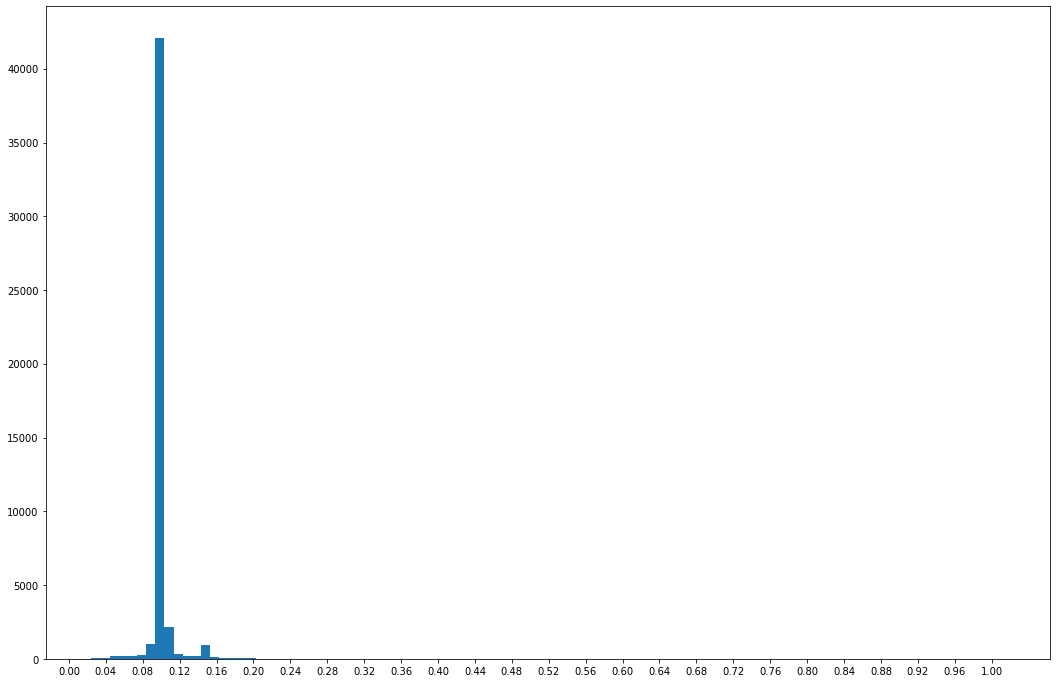

In [36]:
plt.hist(acc_gaps, bins=100)
plt.xticks(np.arange(0, max_acc, round(max_acc / 25, 2)))
plt.show()

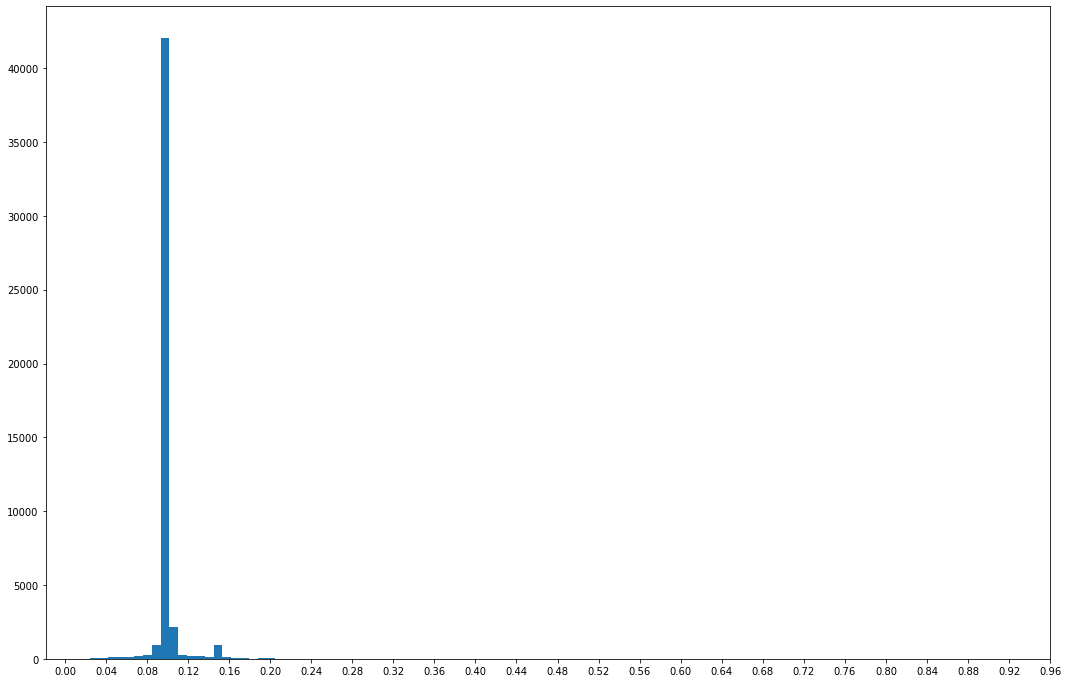

In [37]:
plt.hist([g for g in acc_gaps if g < 1], bins=100)
plt.xticks(np.arange(0, 1, round(1 / 25, 2)))
plt.show()

#### Positions:

In [38]:
pos_gaps = get_gaps(pos_df)

In [39]:
min_pos, max_pos, _, _ = describe(pos_gaps, list_quantiles=[0.5, 0.9, 0.99, 0.999, 0.9999])

Min=0.08637, Max=15.36, Avg=0.1239, Tot=63658
0.5 : 0.1
0.9 : 0.11
0.99 : 0.214
0.999 : 3.001
0.9999 : 15.124


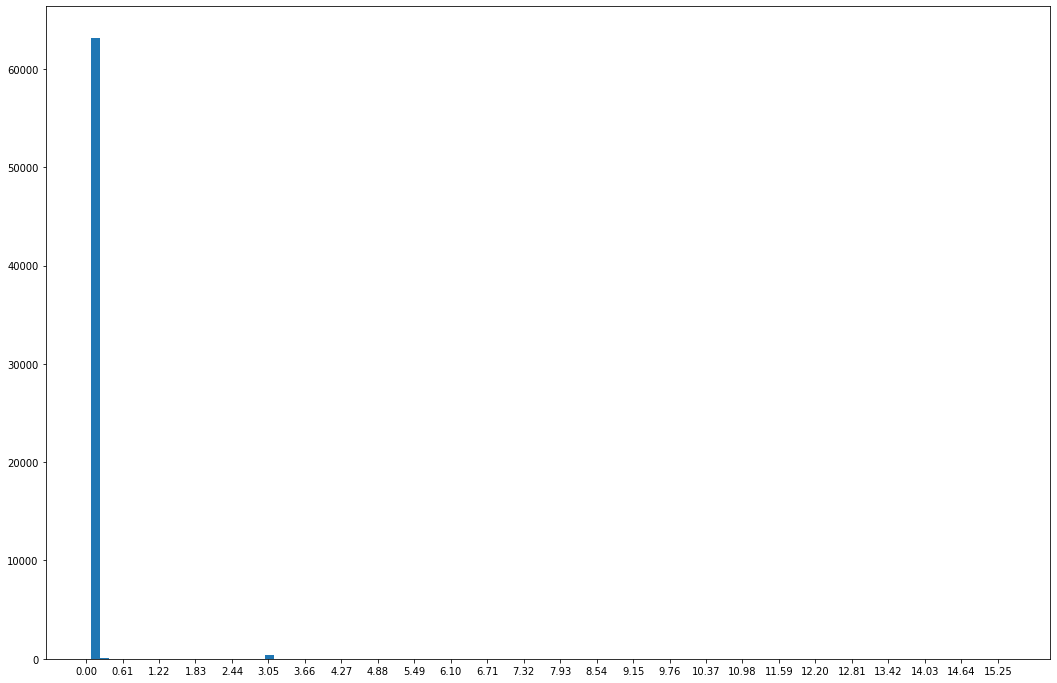

In [40]:
plt.hist(pos_gaps, bins=100)
plt.xticks(np.arange(0, max_pos, round(max_pos / 25, 2)))
plt.show()

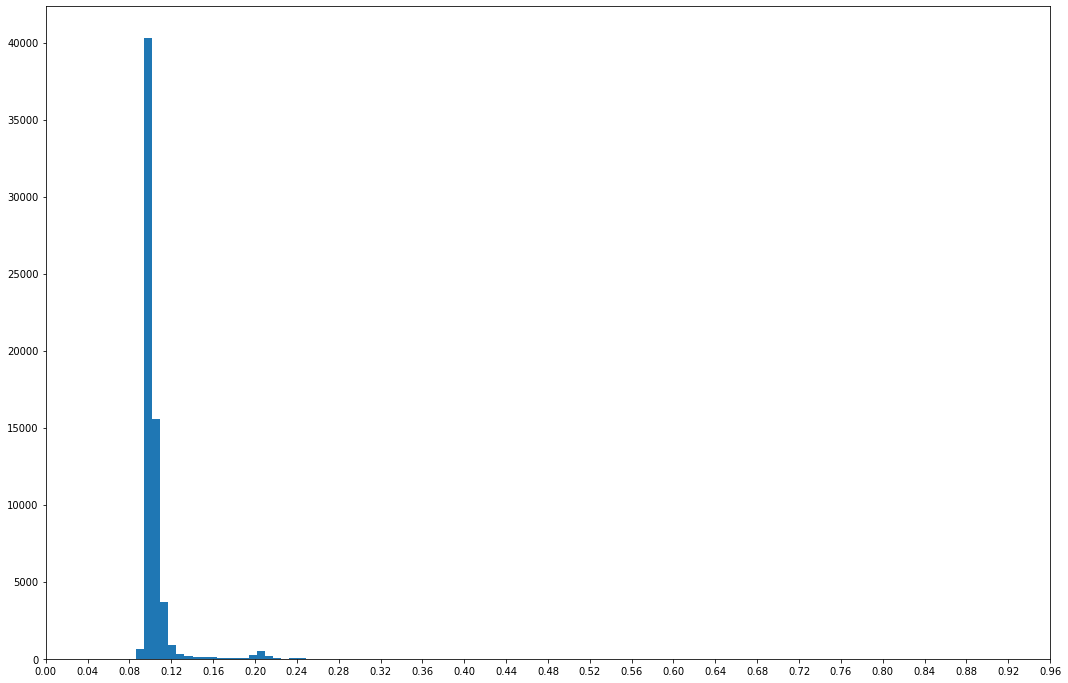

In [41]:
plt.hist([g for g in pos_gaps if g < 1], bins=100)
plt.xticks(np.arange(0, 1, round(1 / 25, 2)))
plt.show()

#### Labels:

In [42]:
lab_gaps = get_gaps(lab_df, are_labels=True)

In [43]:
min_lab, max_lab, _, _ = describe(lab_gaps)

Min=23.66, Max=223.2, Avg=87.72, Tot=55
0.1 : 26.542
0.2 : 27.998
0.3 : 31.741
0.4 : 61.498
0.5 : 67.618
0.6 : 99.179
0.7 : 105.958
0.8 : 137.315
0.9 : 178.663


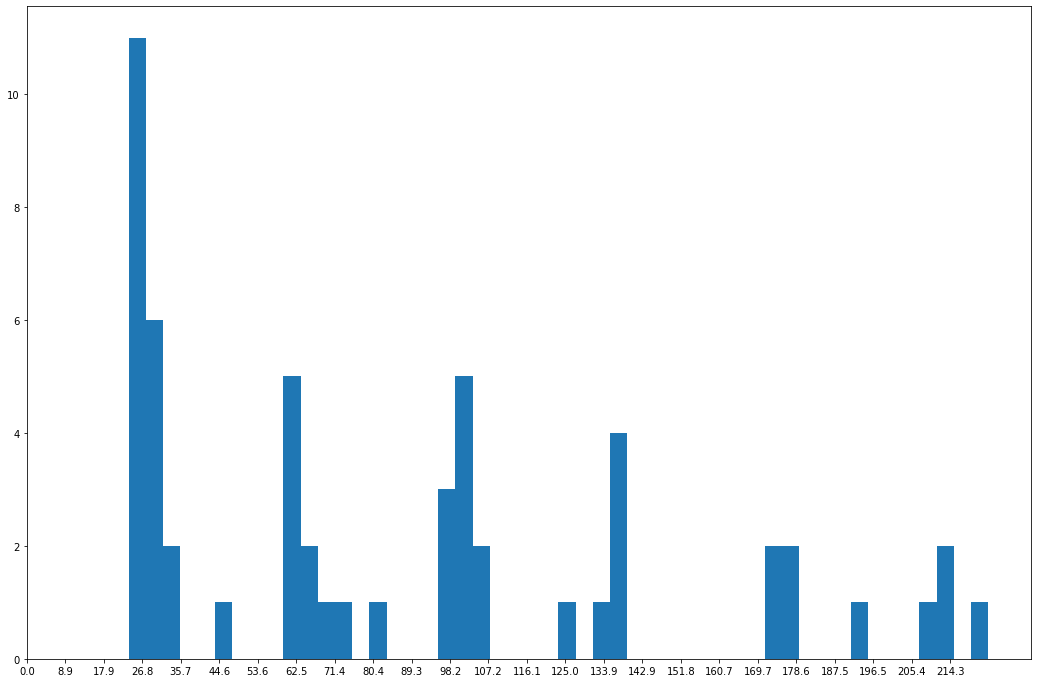

In [44]:
plt.hist(lab_gaps, bins=50)
plt.xticks(np.arange(0, max_lab, round(max_lab / 25, 2)))
plt.show()

#### Time disalignments inter-datasets

In [45]:
min_td, max_td, _, _ = describe(time_disalignments, list_quantiles=[0.5, 0.9, 0.99, 0.999, 0.9999])

Min=7.153e-07, Max=14.31, Avg=0.128, Tot=33862
0.5 : 0.031
0.9 : 0.048
0.99 : 4.438
0.999 : 10.91
0.9999 : 13.967


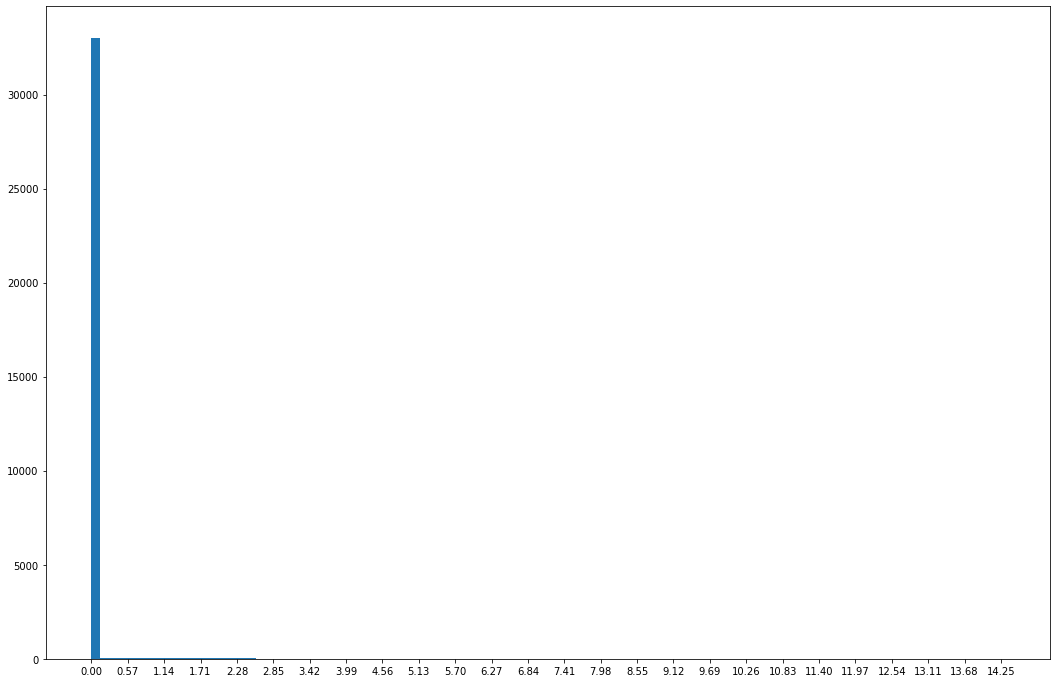

In [46]:
plt.hist(time_disalignments, bins=100)
plt.xticks(np.arange(0, max_td, round(max_td / 25, 2)))
plt.show()

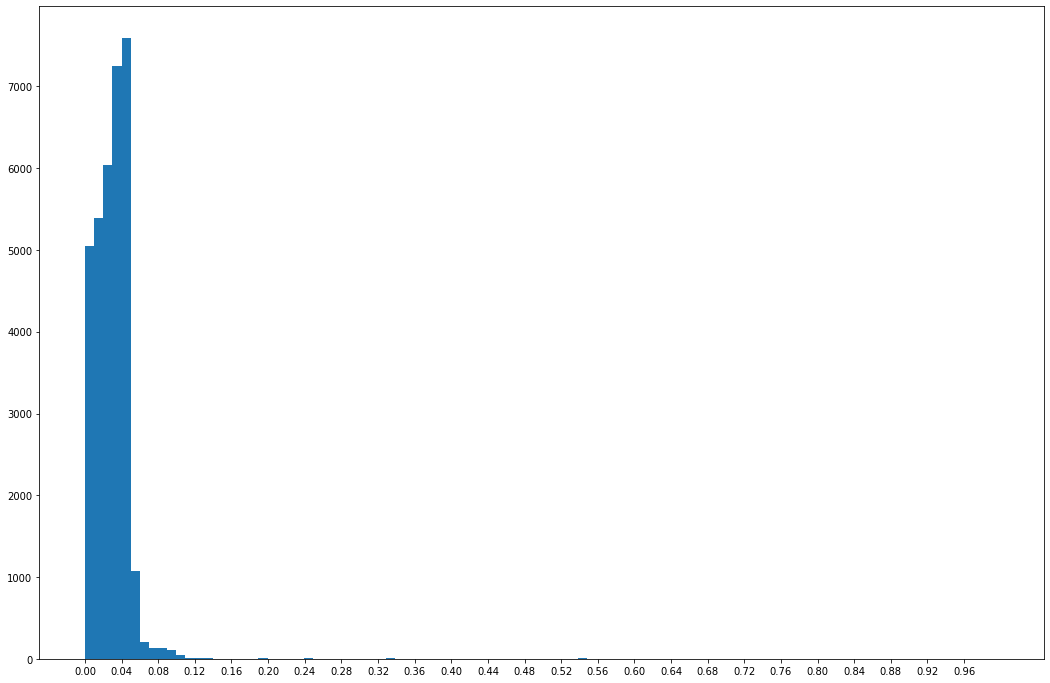

In [47]:
plt.hist([t for t in time_disalignments if t < 1], bins=100)
plt.xticks(np.arange(0, 1, round(1 / 25, 2)))
plt.show()

## Remaining useful life (RUL)

The following plot shows the Remaining Useful Life (RUL), namely the number of time steps before that a failure occurs.

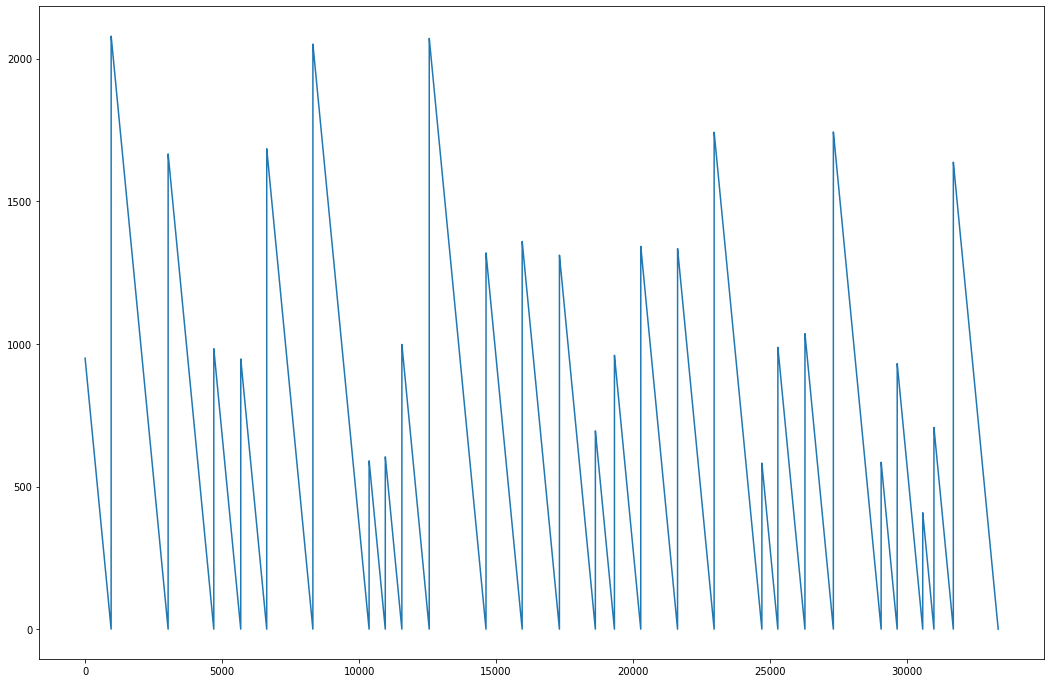

In [48]:
plt.plot(df["label"])
plt.show()

## Data trends visualization

In [49]:
def plot_all_signal(df, feature):
    plt.plot(df[feature], alpha=0.6)
    plt.plot(df["POSy"])
    ranges = (df["label"] == 0).map({True:0, False:30})
    plt.scatter(range(len(df)), ranges, color="red", s=20)
    plt.ylim(-9,5)
    plt.show()

In [50]:
def plot_all_signal_zoomed(df, feature):
    for i in range(0, len(df) - 2000, 2000):
        start = i
        end = i + 2000
        plt.plot(df[feature][start:end], alpha=0.6)
        plt.plot(df["POSy"][start:end])
        ranges = (df["label"] == 0).map({True:0, False:30})
        plt.scatter(range(start, end), ranges[start:end], color="red", s=20)
        plt.ylim(-9, 5)
        plt.show()

In [51]:
def plot_only_faults(df, feature):
    for i, is_fault in enumerate((df["label"] == 0).tolist()):
        if is_fault:
            start = i - 20
            end = i + 1
            plt.plot(df[feature][start:end], alpha=0.6)
            plt.plot(df["POSy"][start:end])
            ranges = (df["label"] == 0).map({True:0, False:30})
            plt.scatter(range(start, end), ranges[start:end], color="red", s=20)
            plt.ylim(-9, 5)
            plt.show()

In [52]:
list(df.columns)  # select among these features

['Gz',
 'Ax',
 'Ay',
 'Gz_diff',
 'Ax_diff',
 'Ay_diff',
 'Gz_mean_w5',
 'Ax_mean_w5',
 'Ay_mean_w5',
 'Gz_std_w5',
 'Ax_std_w5',
 'Ay_std_w5',
 'Gz_min_w5',
 'Ax_min_w5',
 'Ay_min_w5',
 'Gz_max_w5',
 'Ax_max_w5',
 'Ay_max_w5',
 'Gz_mean_w10',
 'Ax_mean_w10',
 'Ay_mean_w10',
 'Gz_std_w10',
 'Ax_std_w10',
 'Ay_std_w10',
 'Gz_min_w10',
 'Ax_min_w10',
 'Ay_min_w10',
 'Gz_max_w10',
 'Ax_max_w10',
 'Ay_max_w10',
 'Gz_mean_w15',
 'Ax_mean_w15',
 'Ay_mean_w15',
 'Gz_std_w15',
 'Ax_std_w15',
 'Ay_std_w15',
 'Gz_min_w15',
 'Ax_min_w15',
 'Ay_min_w15',
 'Gz_max_w15',
 'Ax_max_w15',
 'Ay_max_w15',
 'Gz_mean_w20',
 'Ax_mean_w20',
 'Ay_mean_w20',
 'Gz_std_w20',
 'Ax_std_w20',
 'Ay_std_w20',
 'Gz_min_w20',
 'Ax_min_w20',
 'Ay_min_w20',
 'Gz_max_w20',
 'Ax_max_w20',
 'Ay_max_w20',
 'POSx',
 'POSy',
 'orient',
 'differencing_Gz',
 'differencing_Ax',
 'differencing_Ay',
 'differencing_Gz_diff',
 'differencing_Ax_diff',
 'differencing_Ay_diff',
 'differencing_Gz_mean_w5',
 'differencing_Ax_mean_w5',
 'd

In [53]:
feature = "differencing_Ax_min_w5"  # select feature to analyze here

#### Analysis

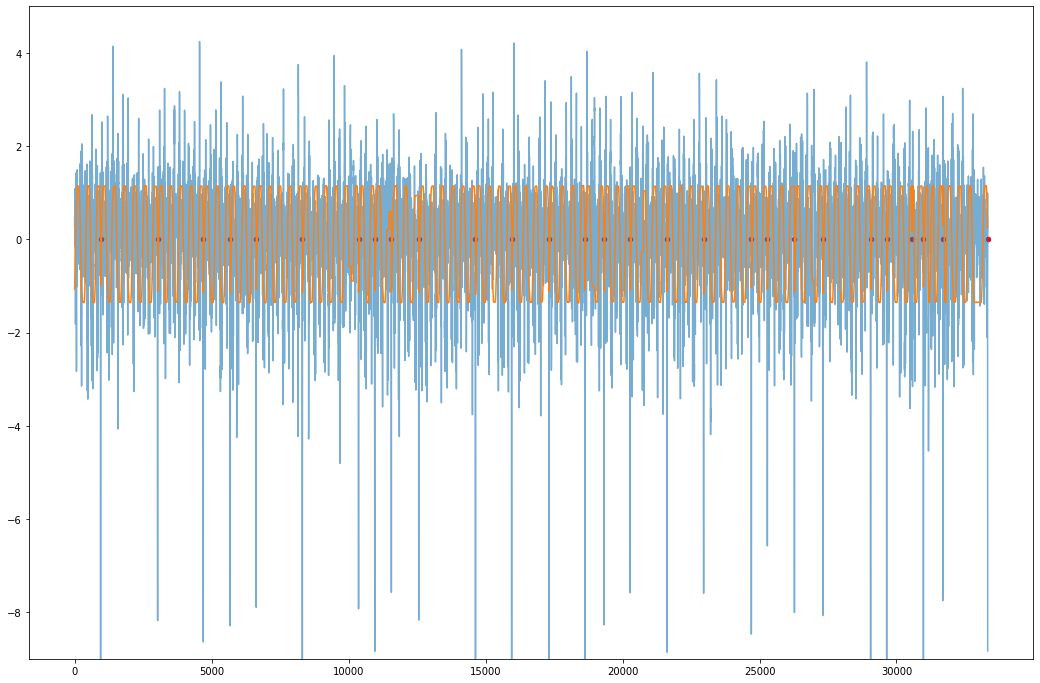

In [54]:
plot_all_signal(df, feature)

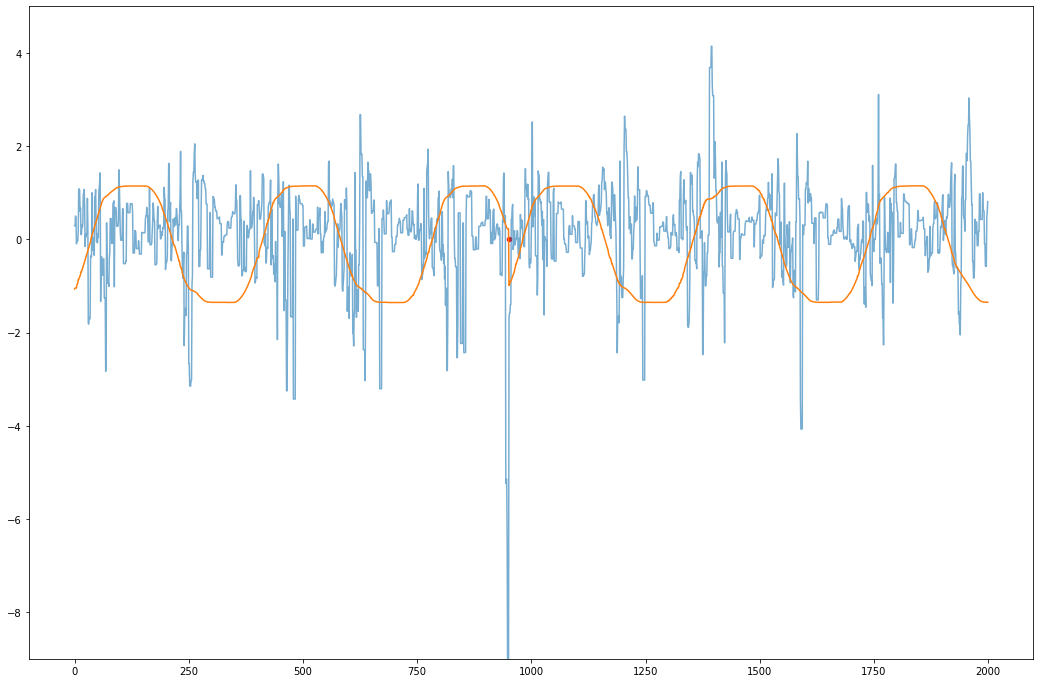

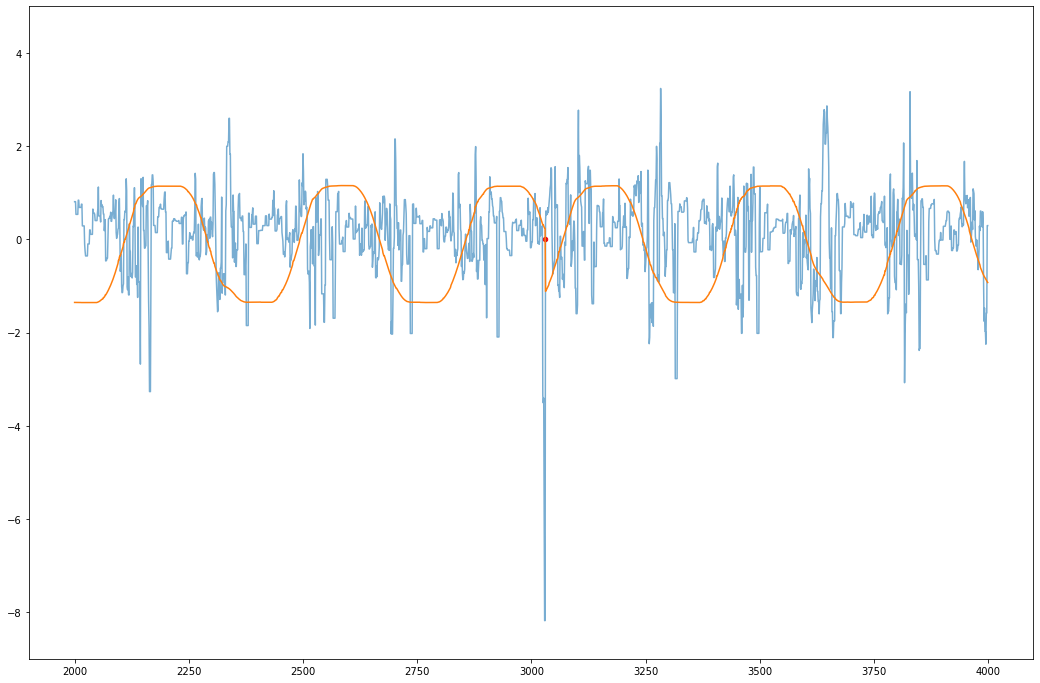

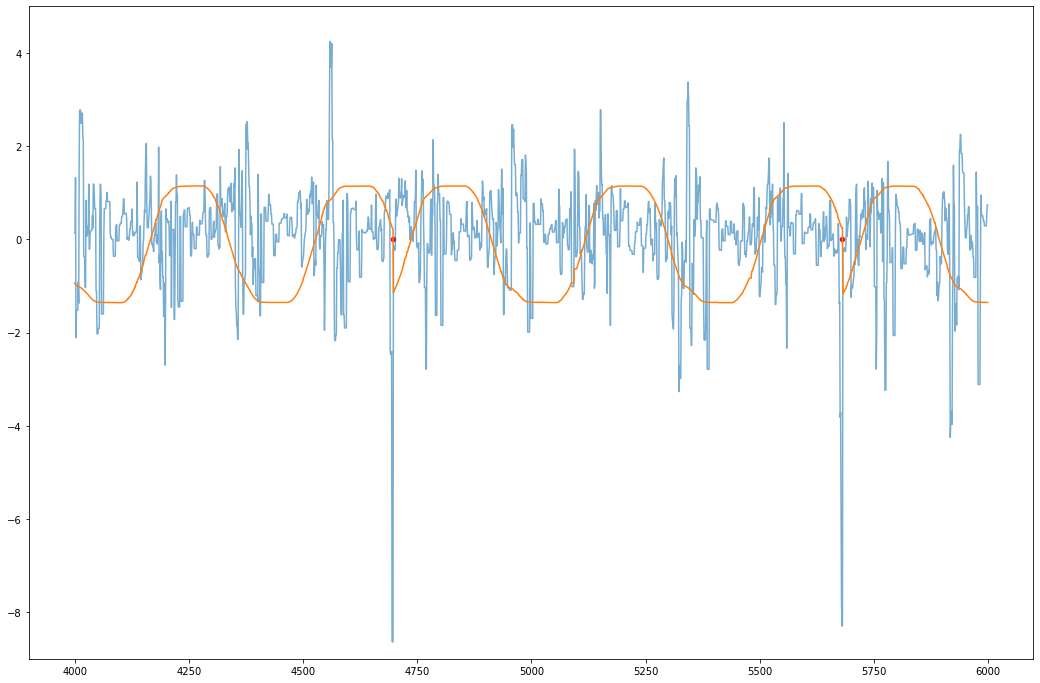

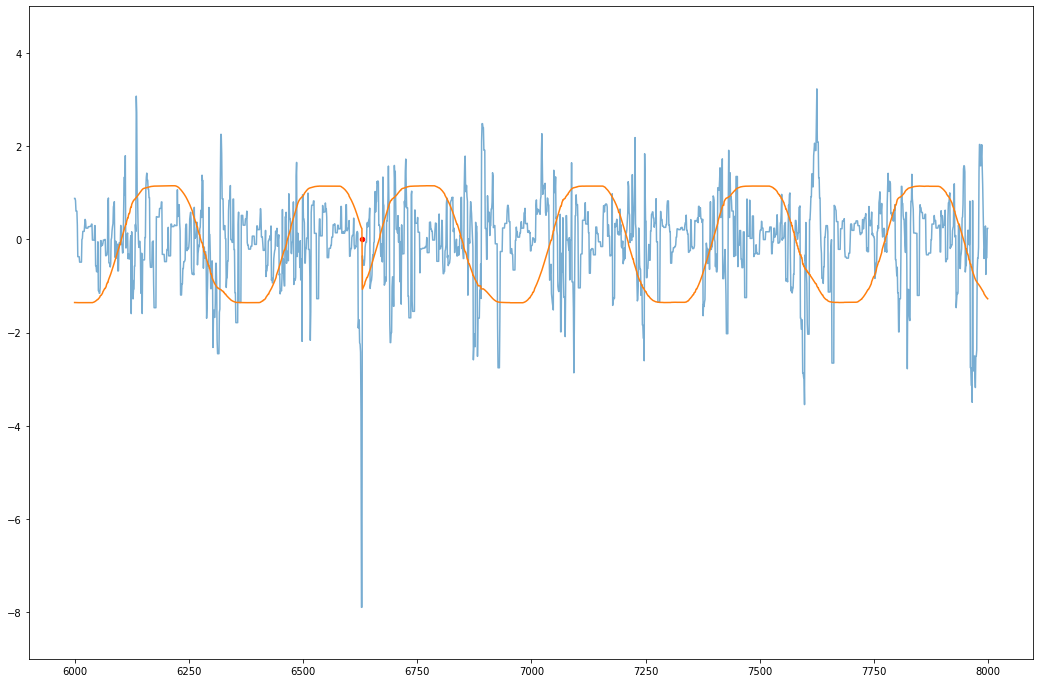

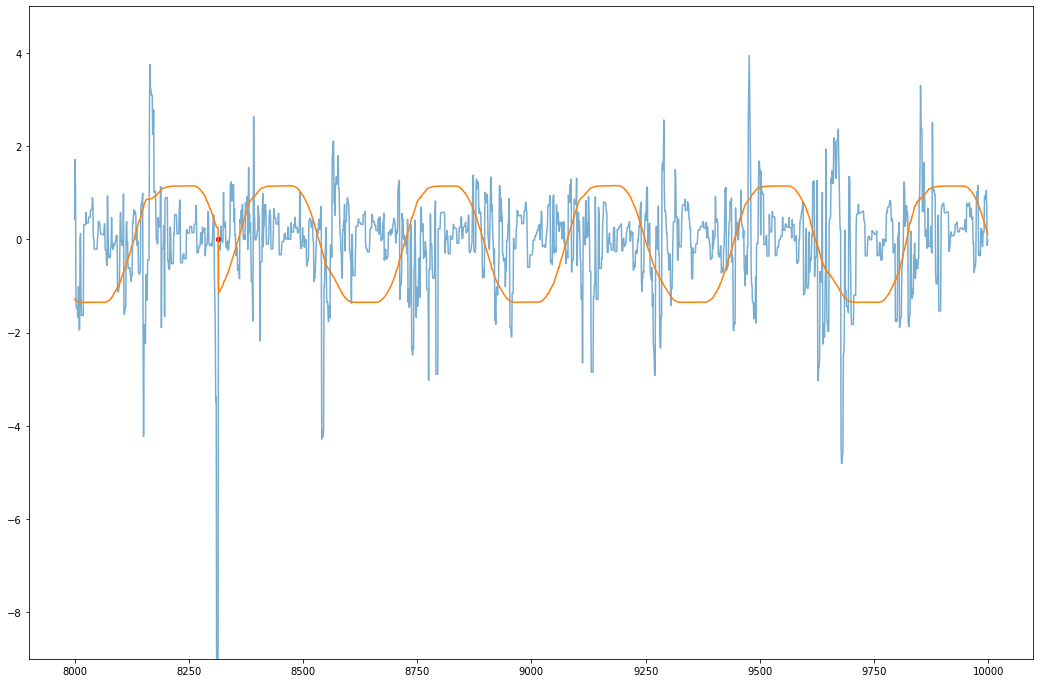

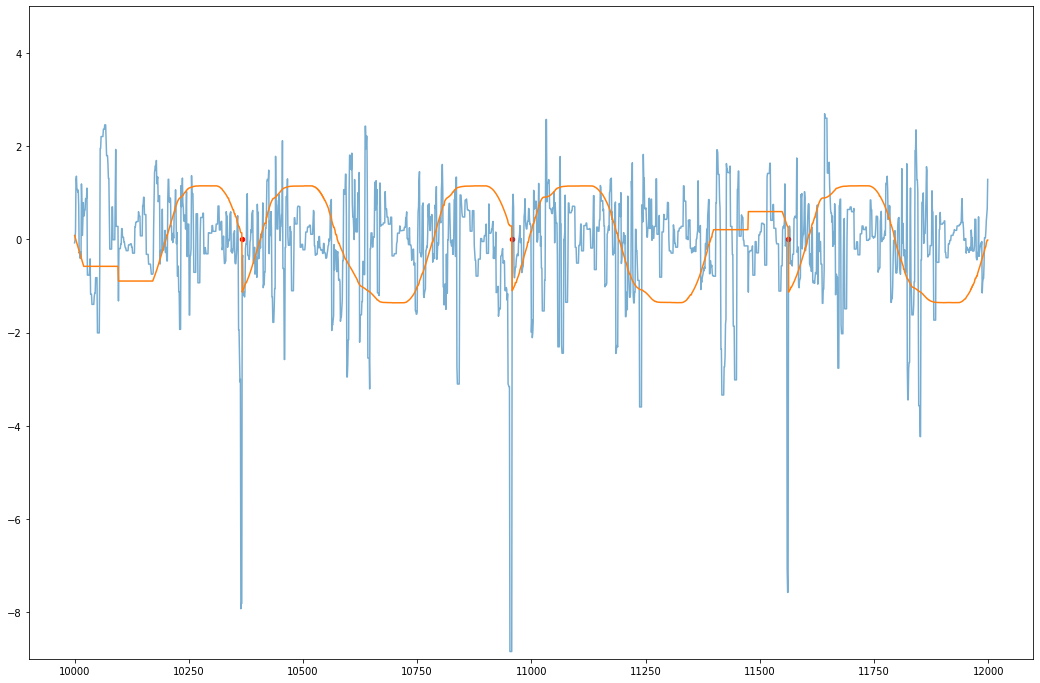

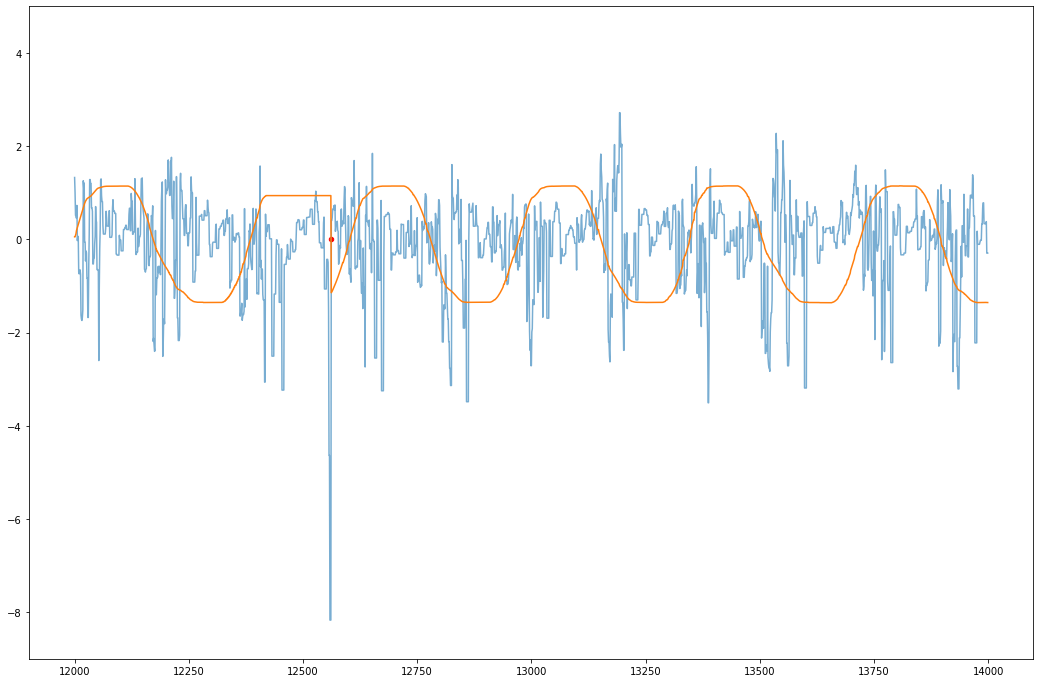

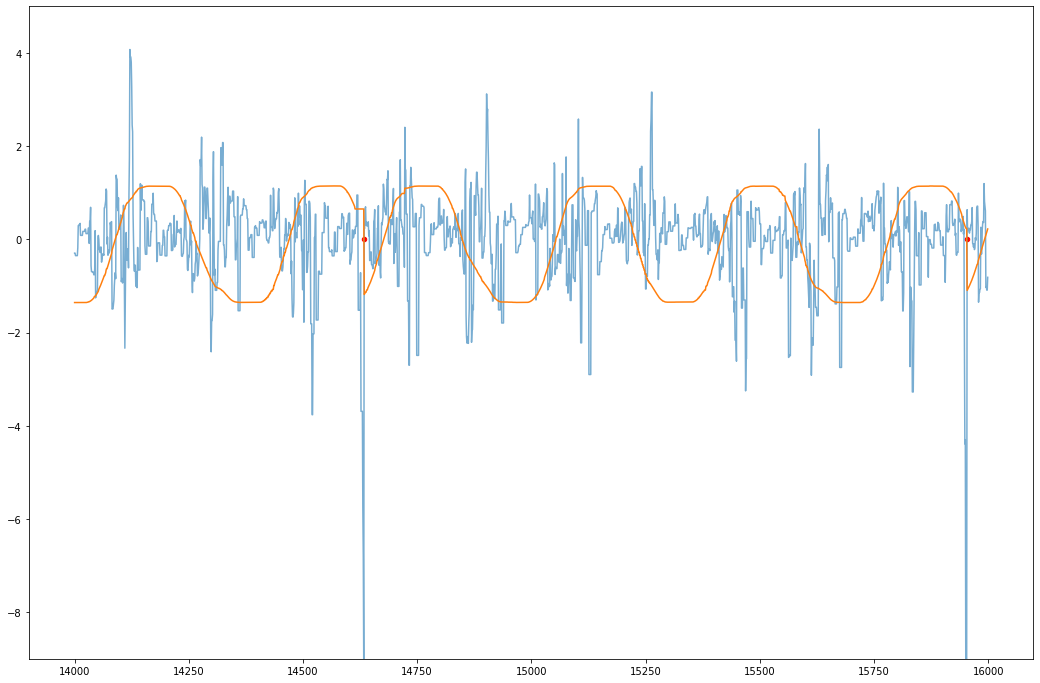

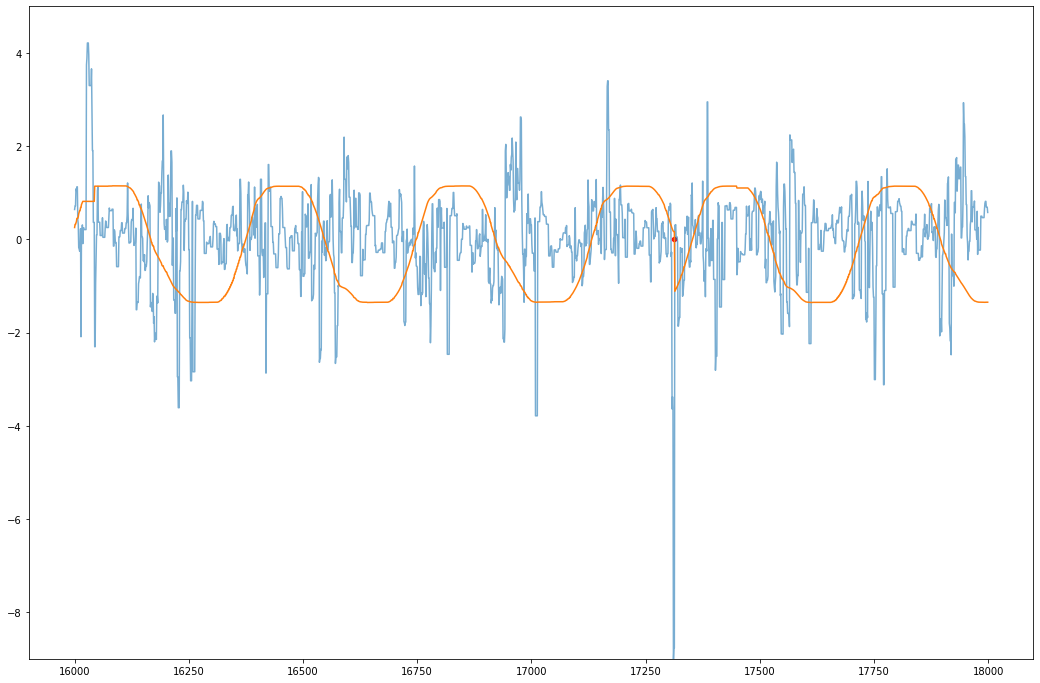

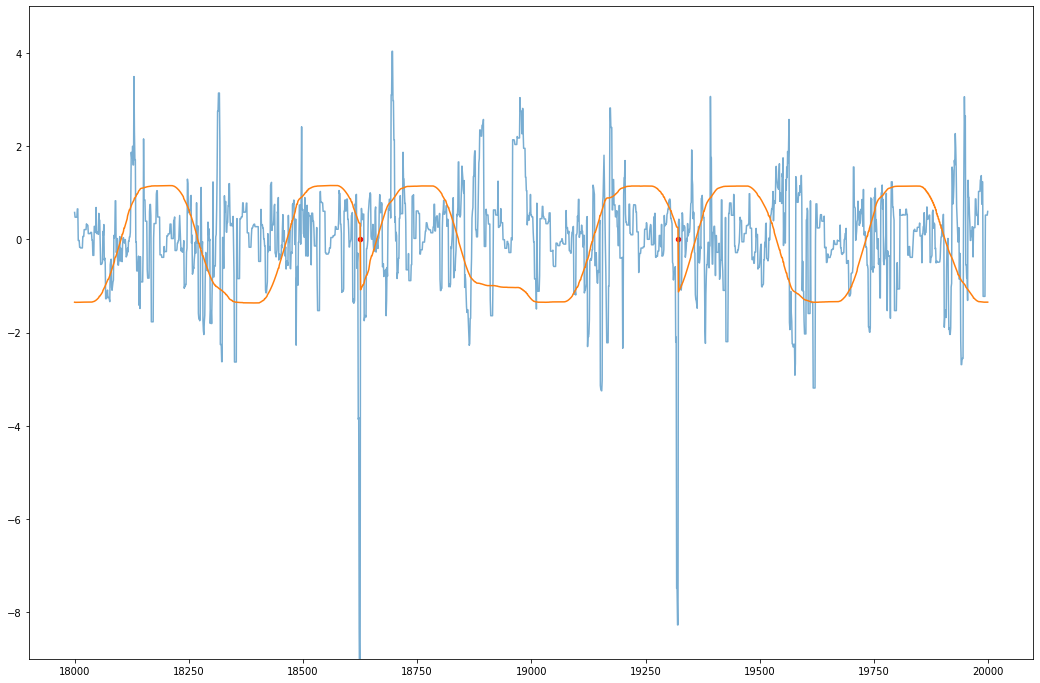

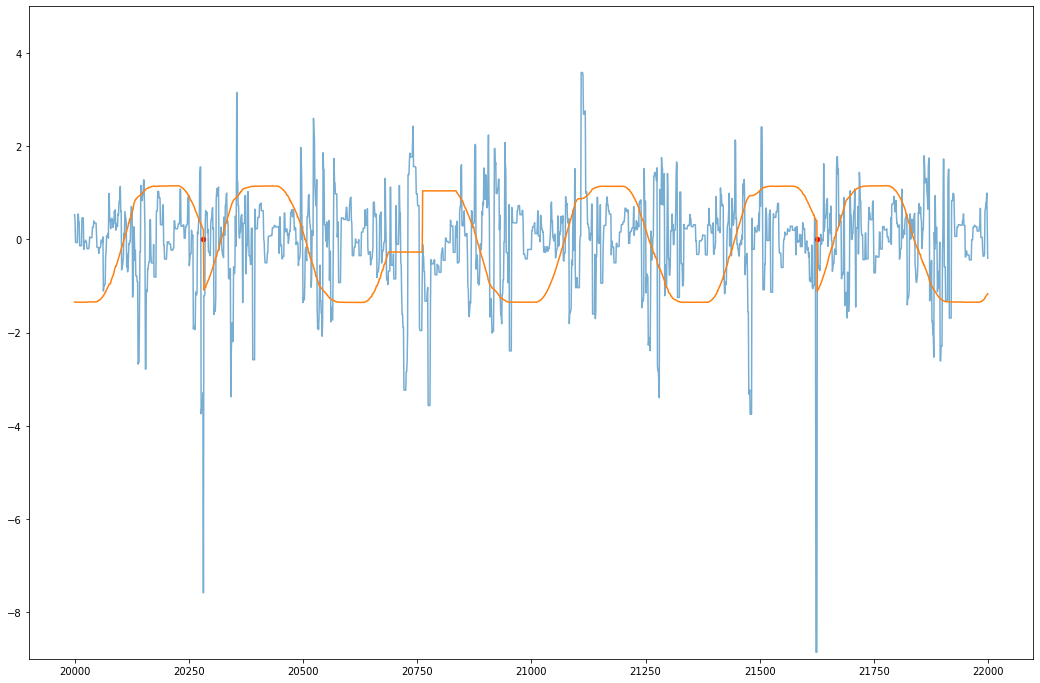

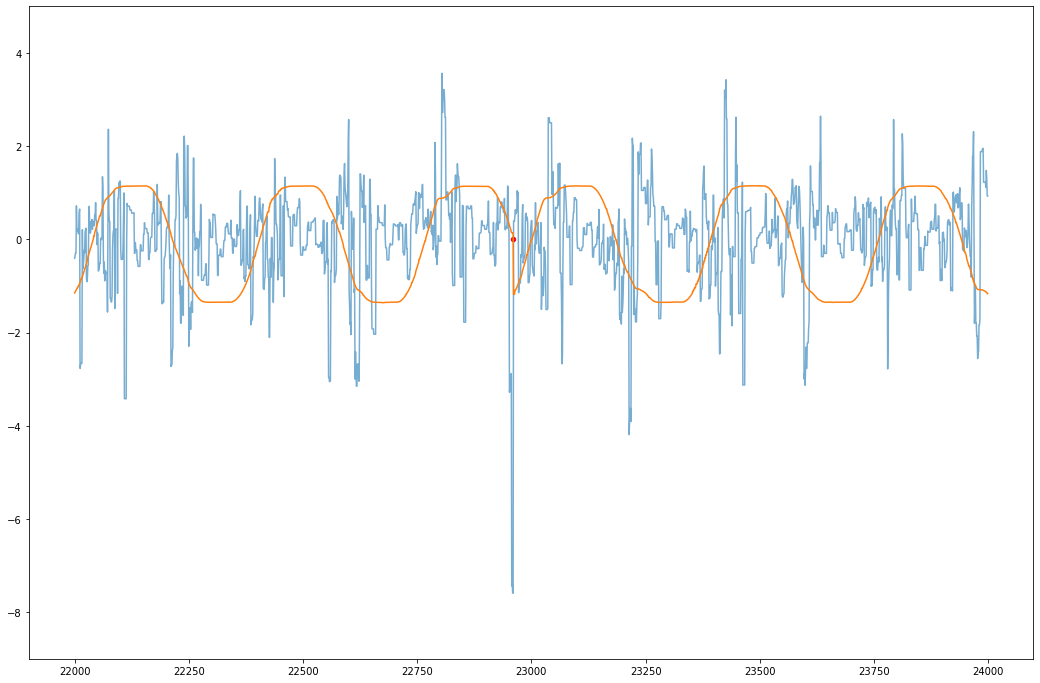

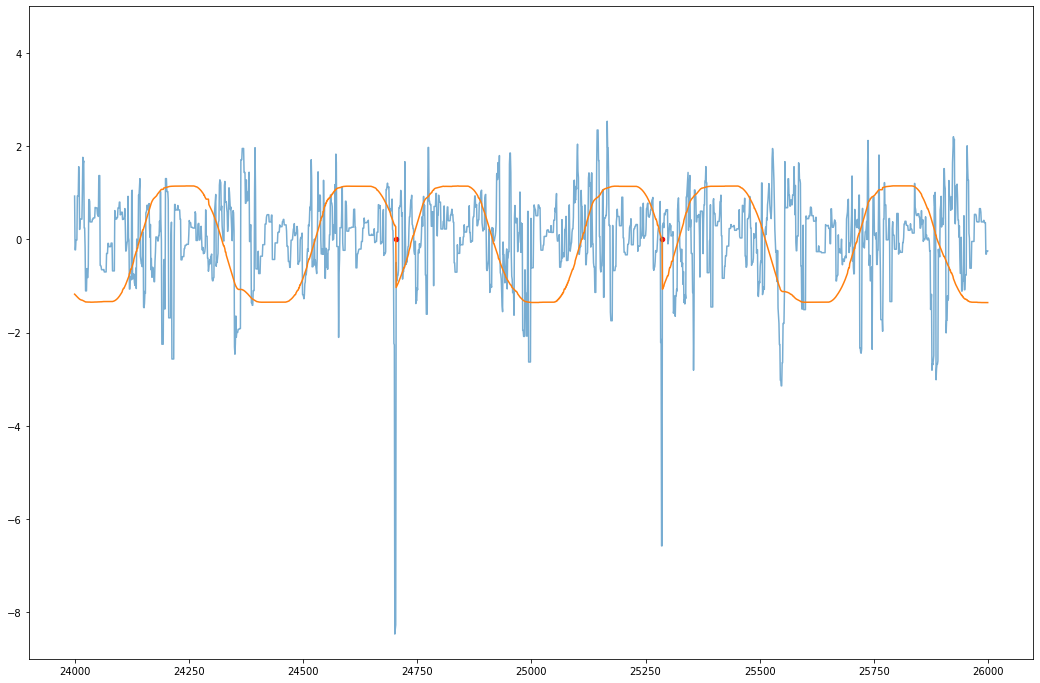

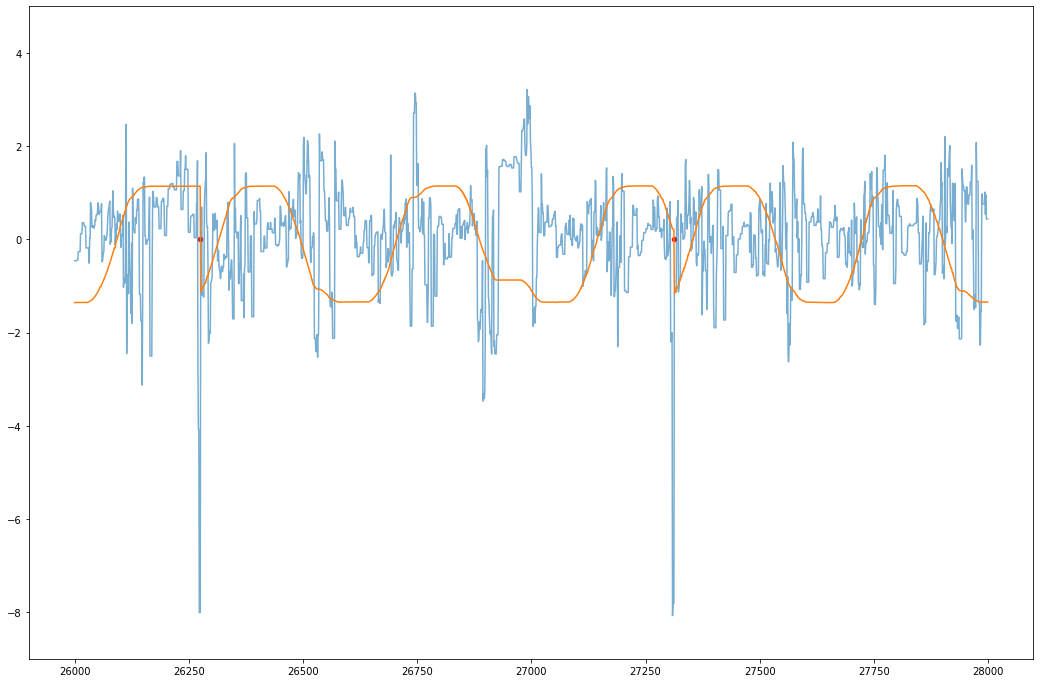

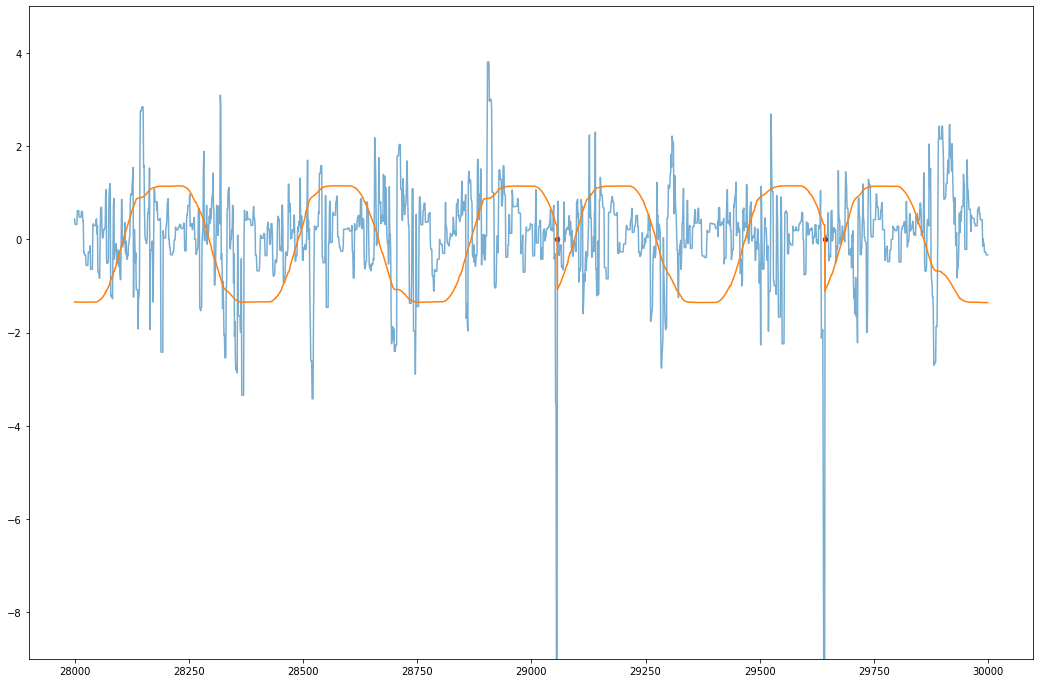

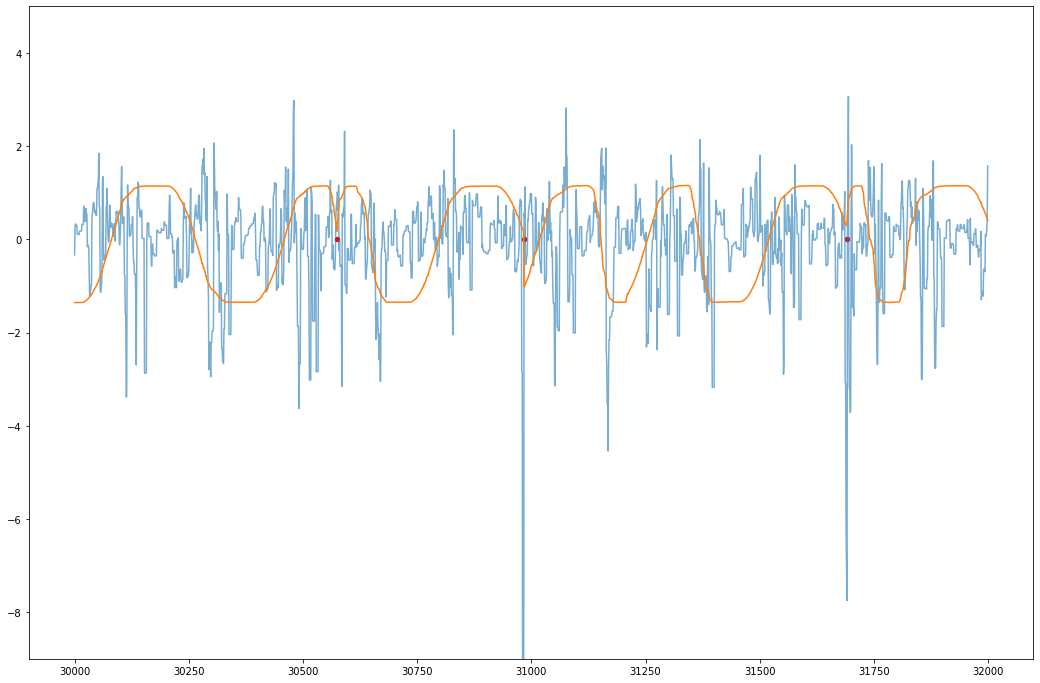

In [55]:
plot_all_signal_zoomed(df, feature)

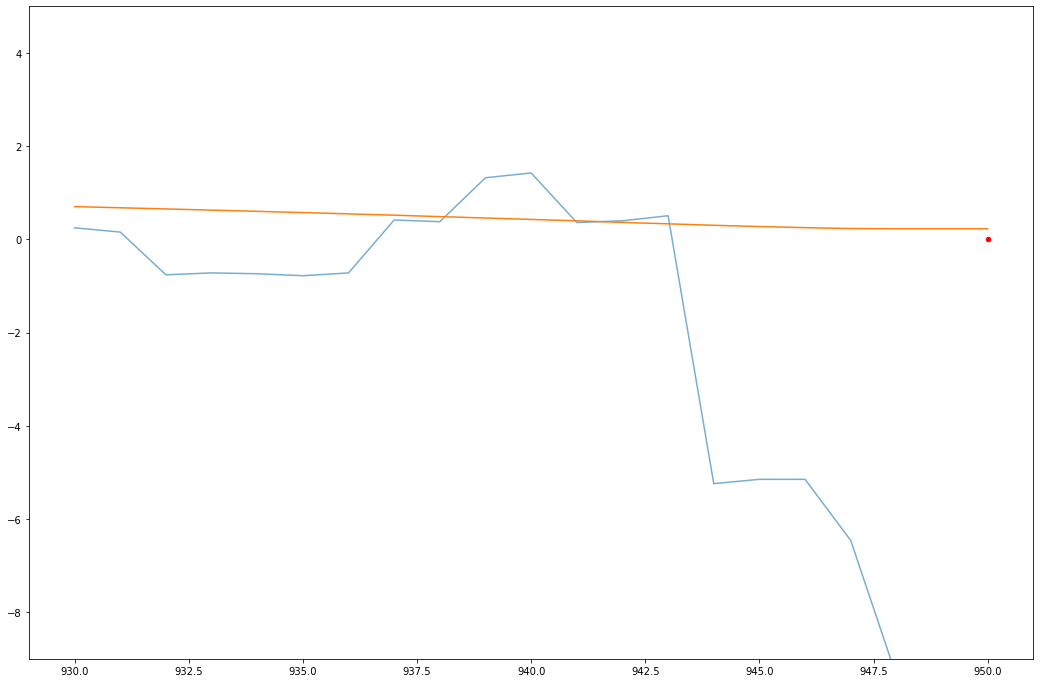

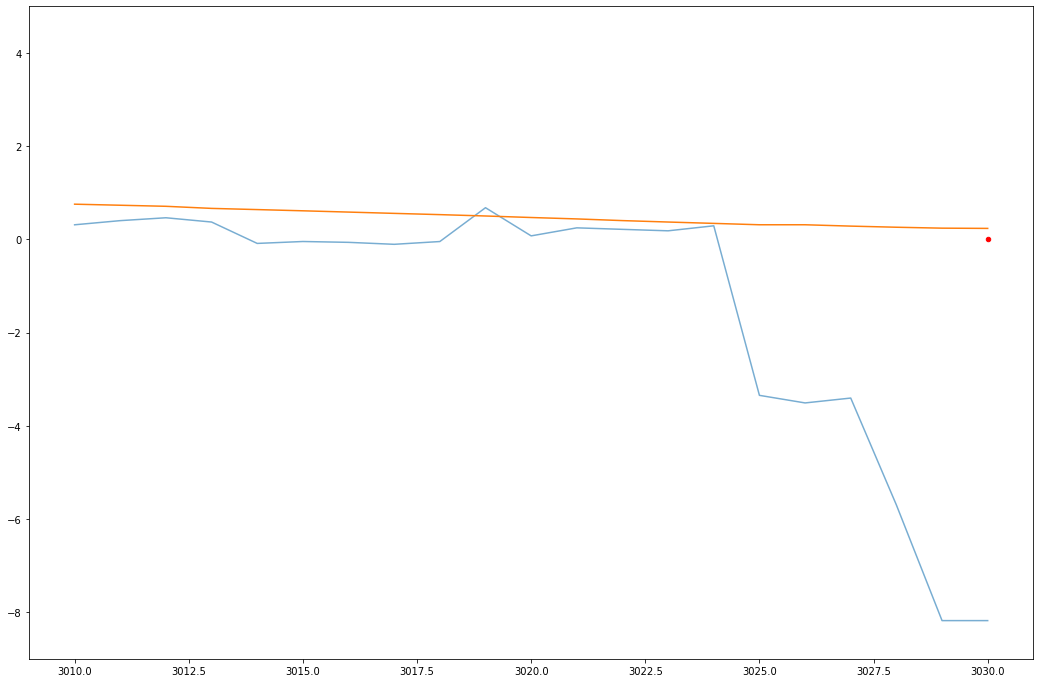

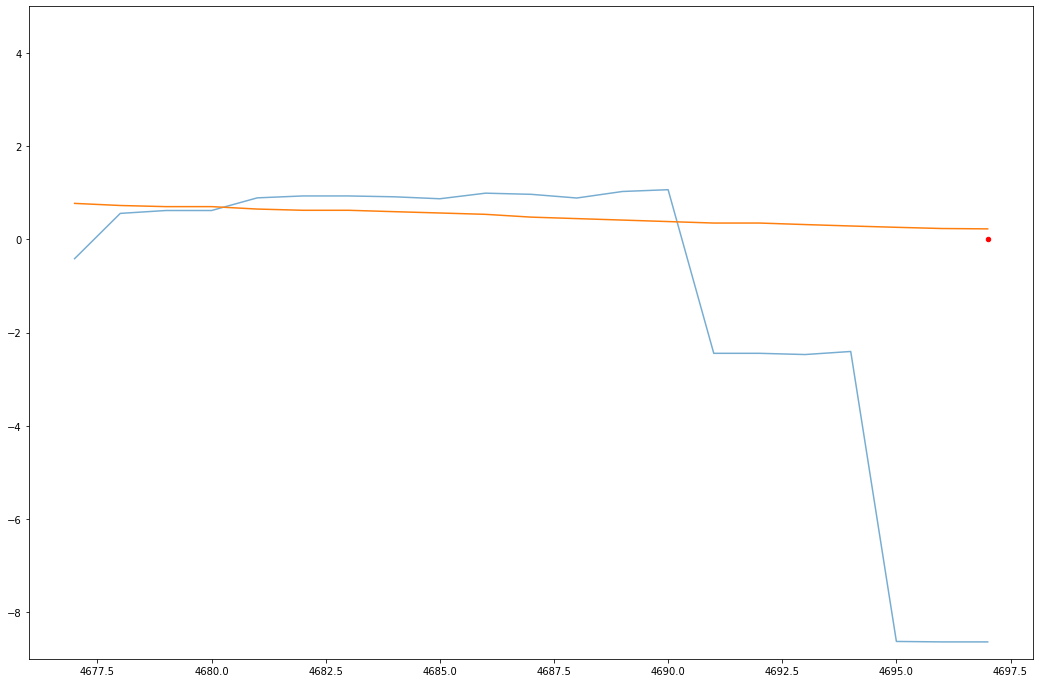

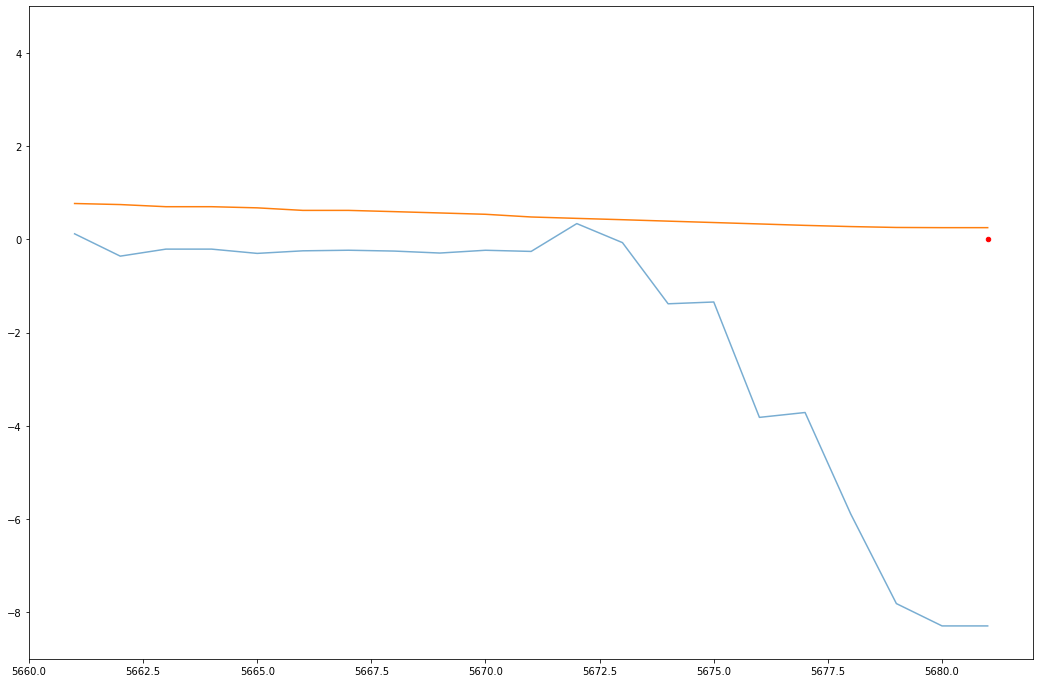

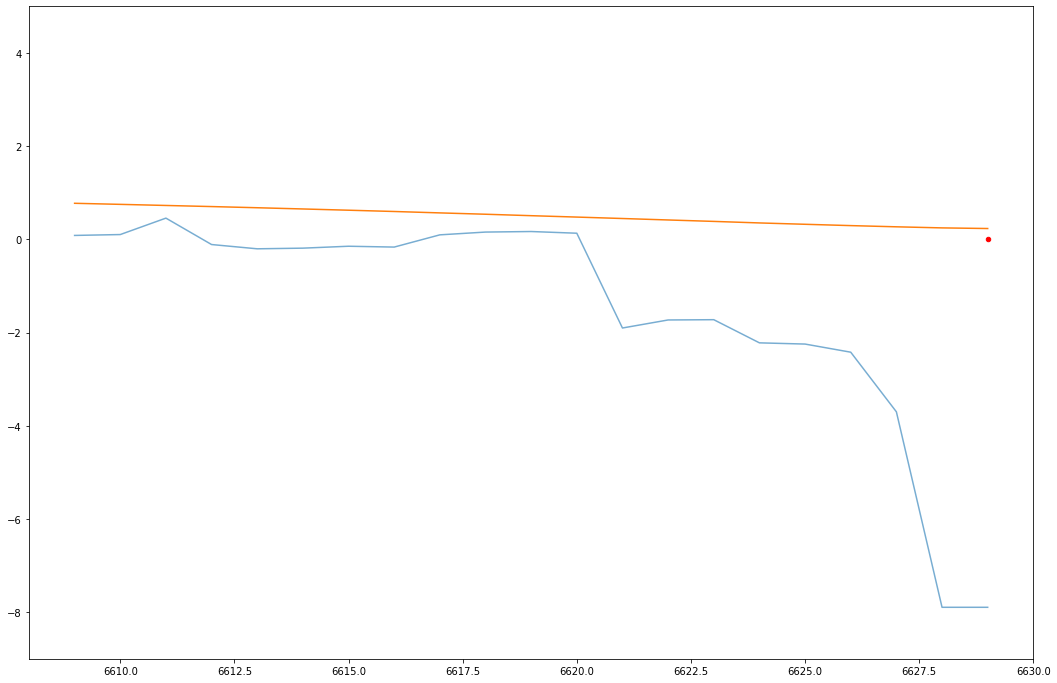

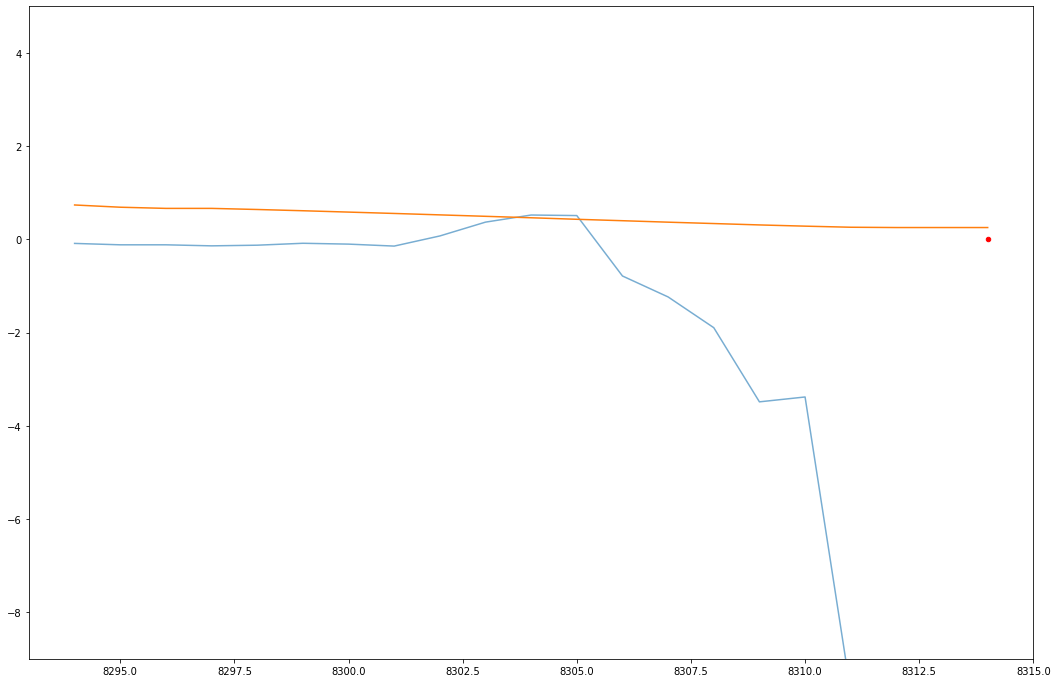

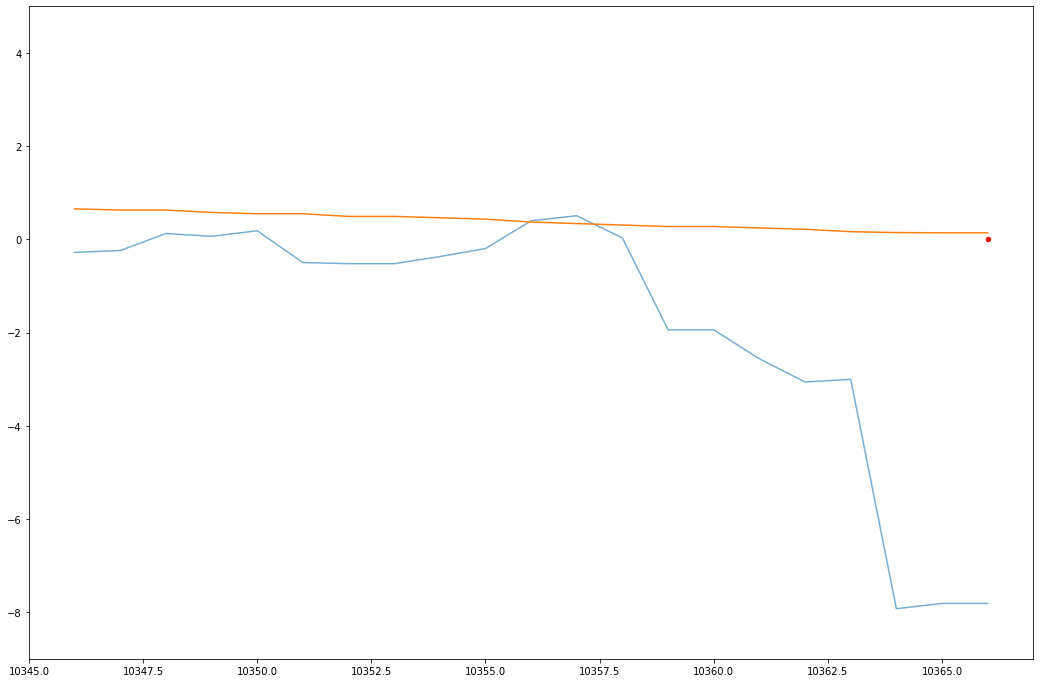

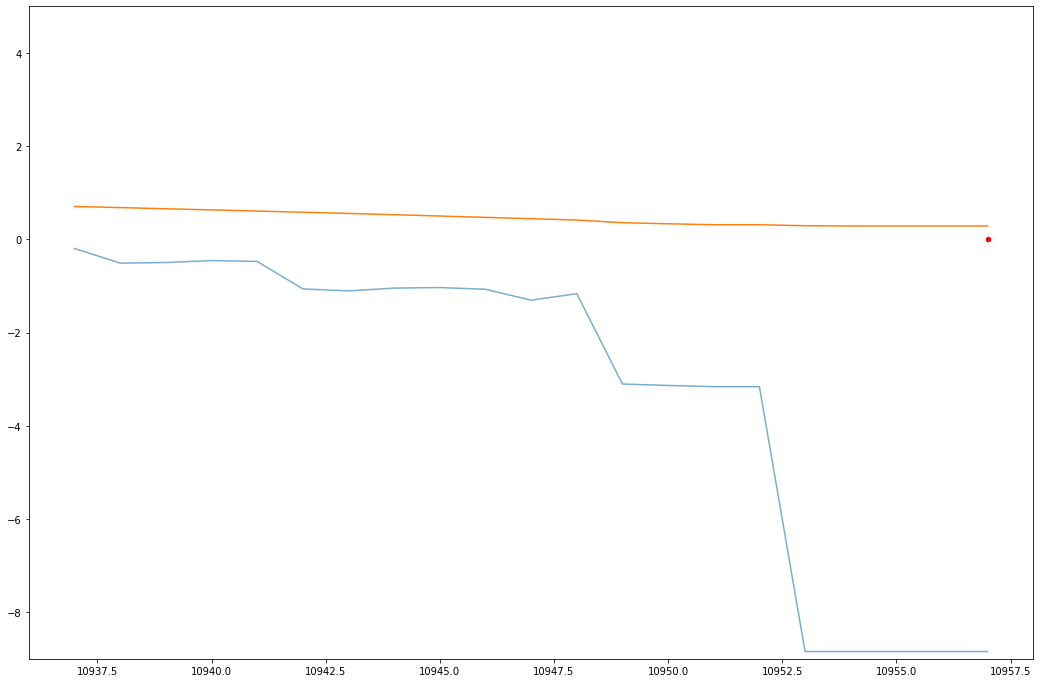

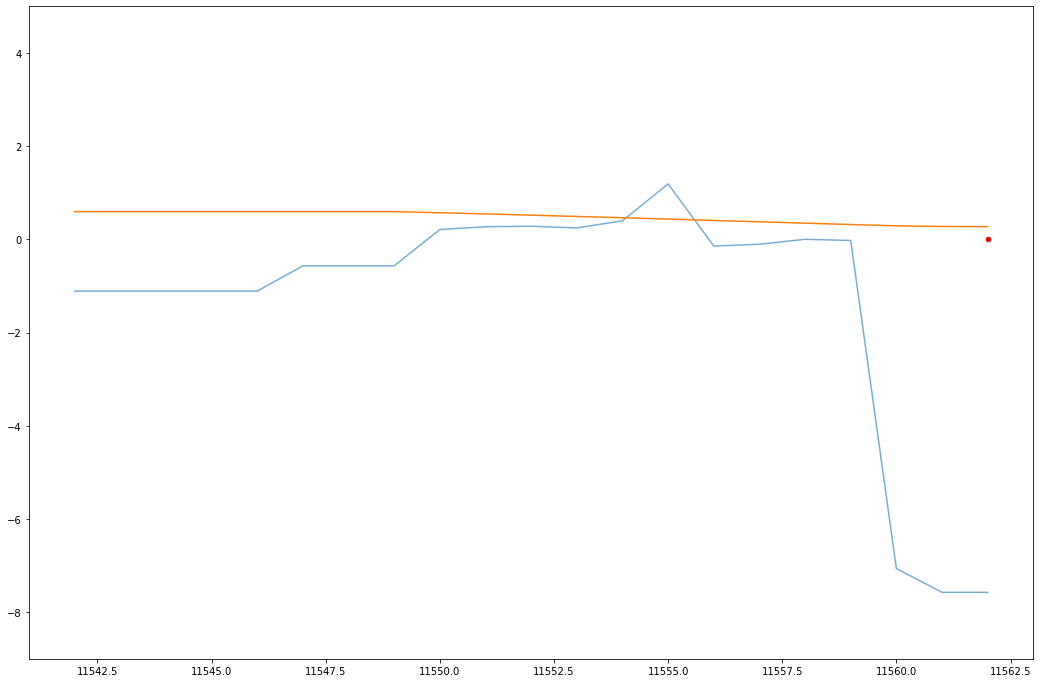

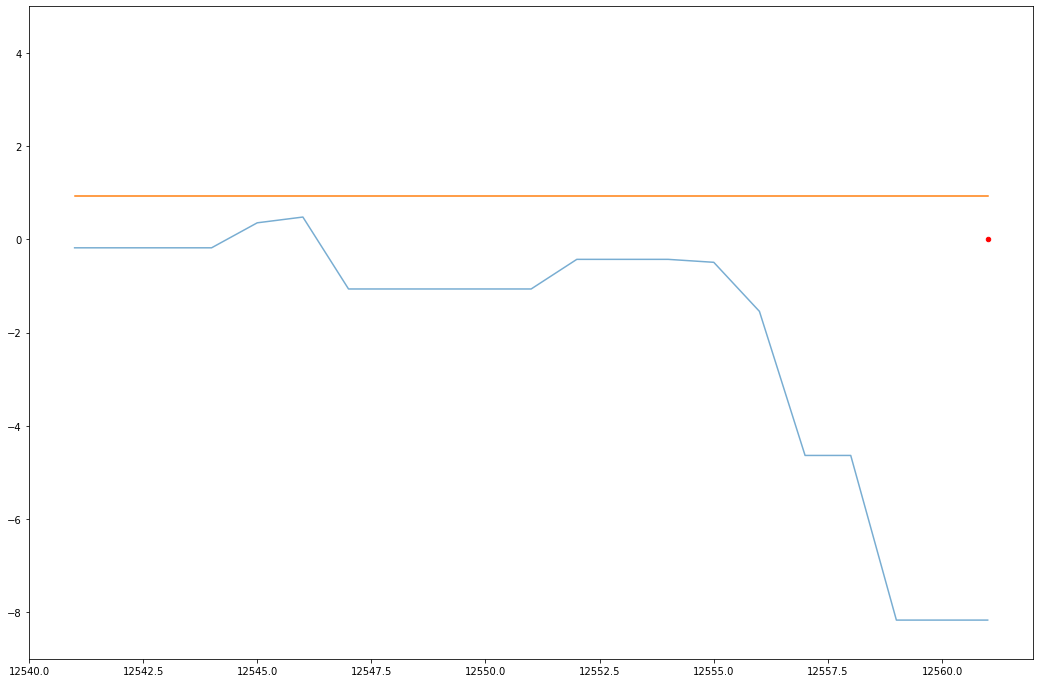

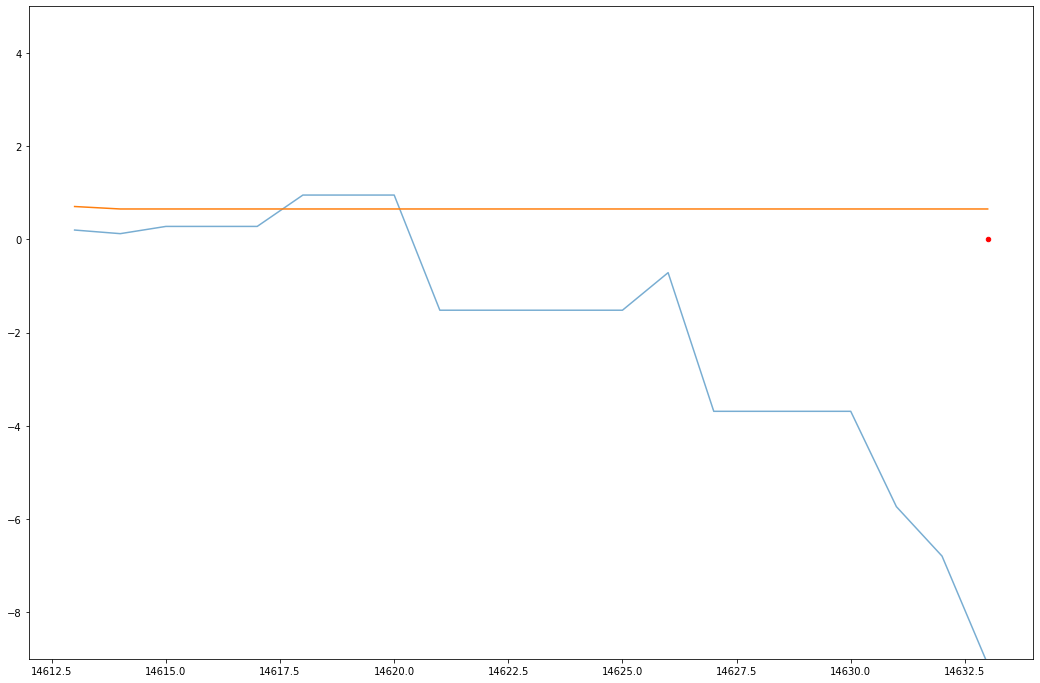

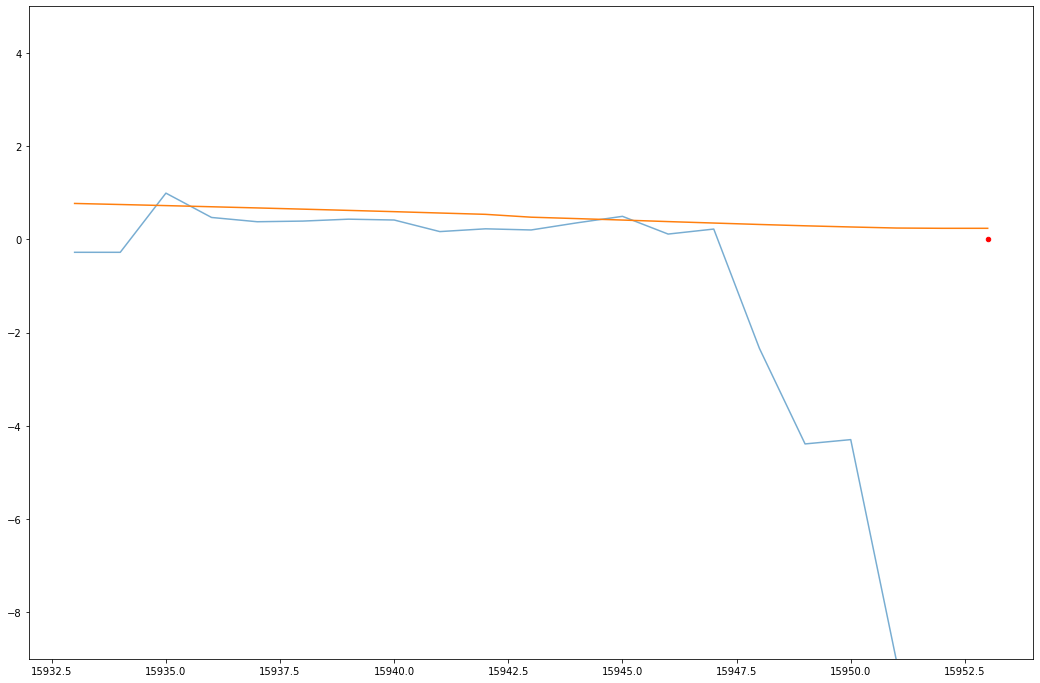

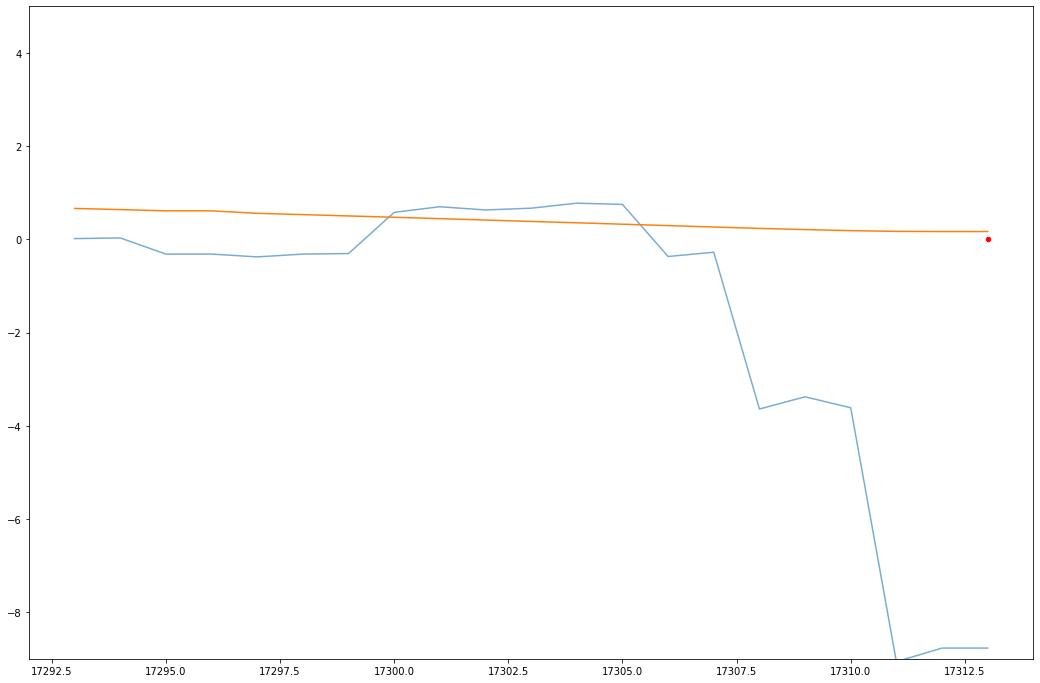

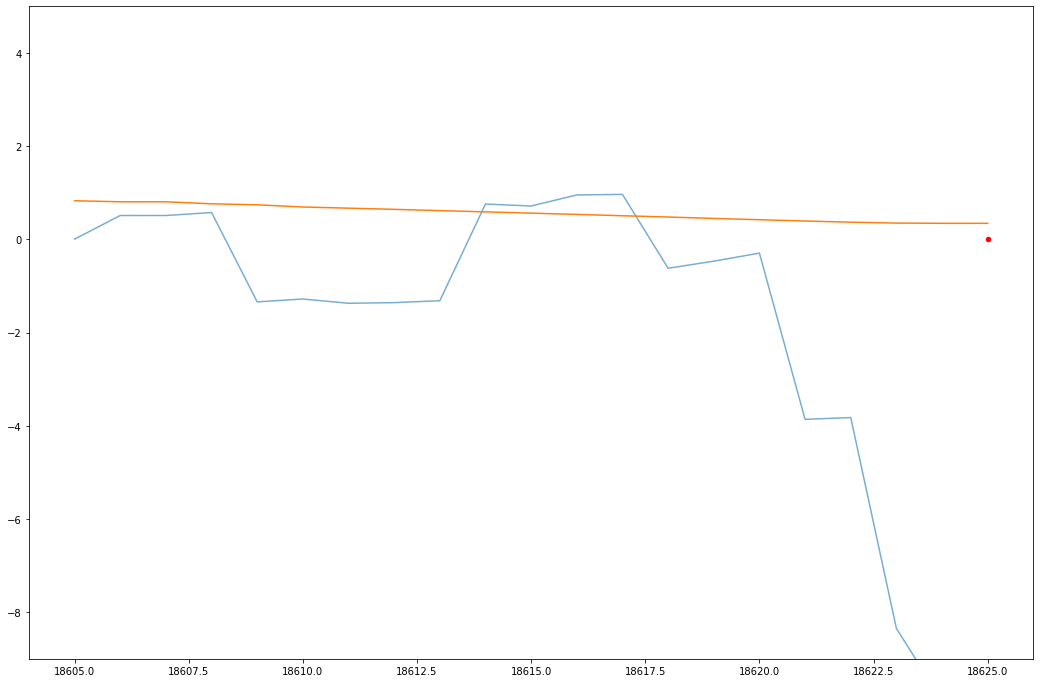

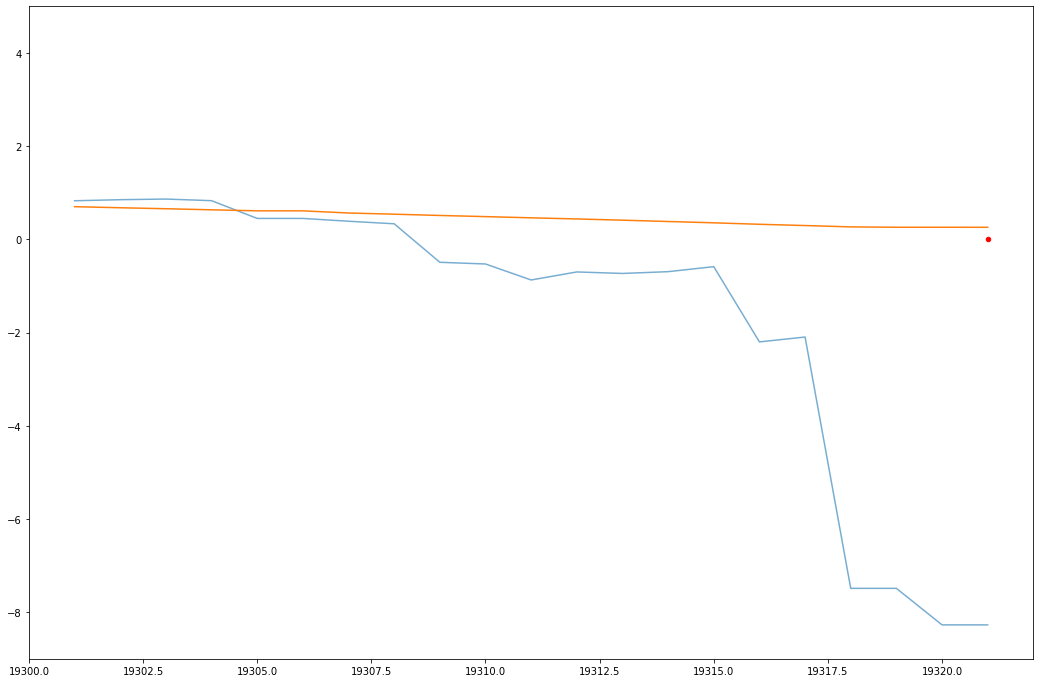

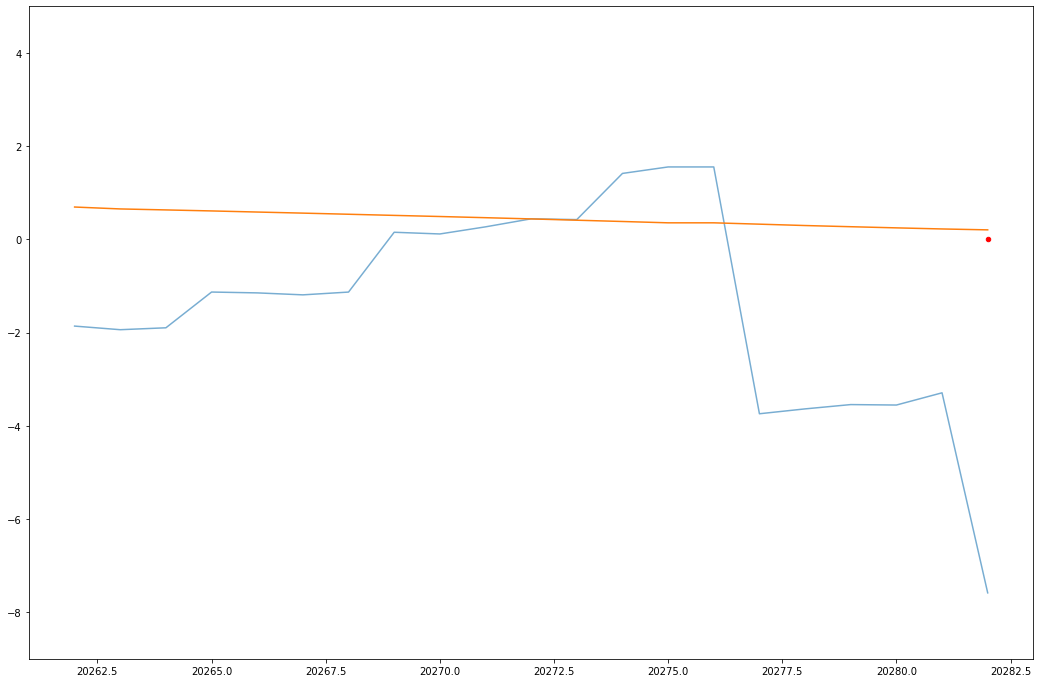

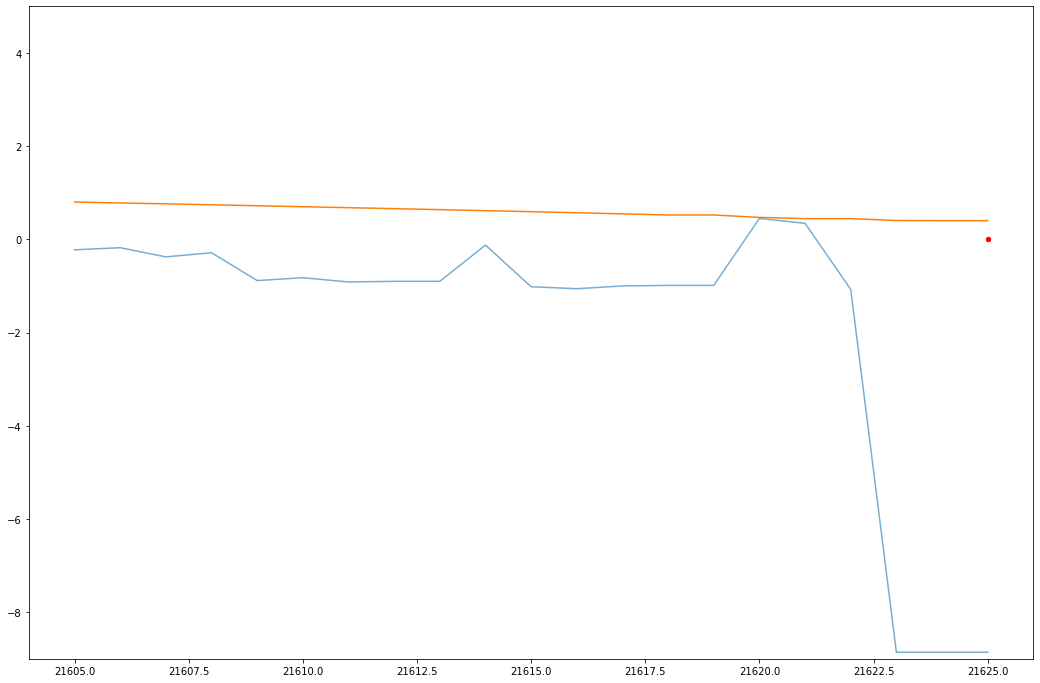

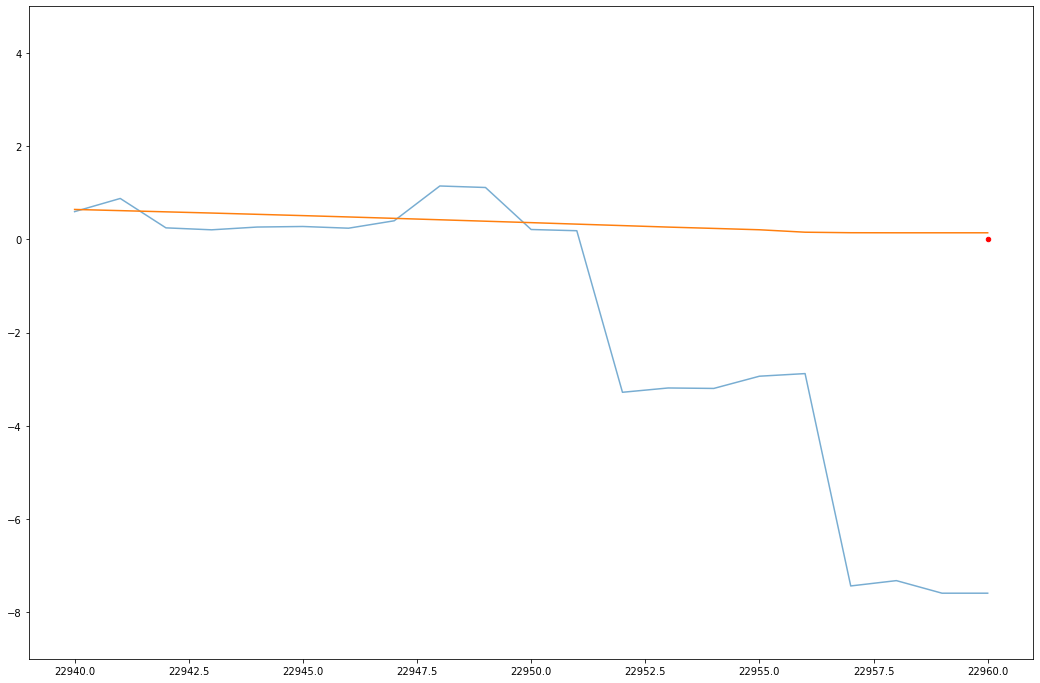

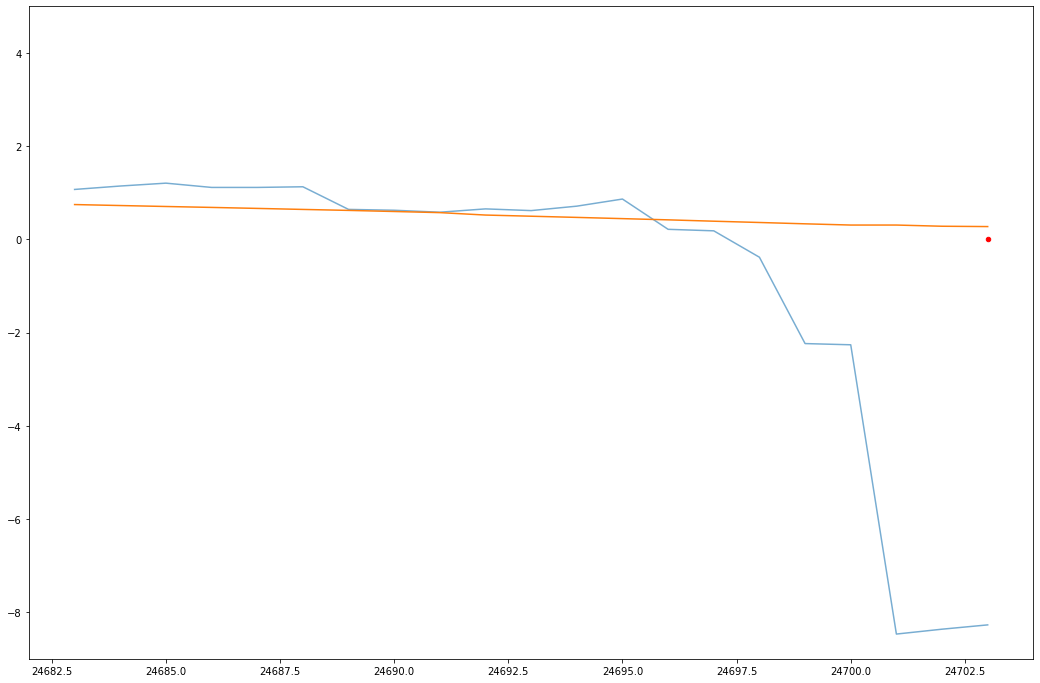

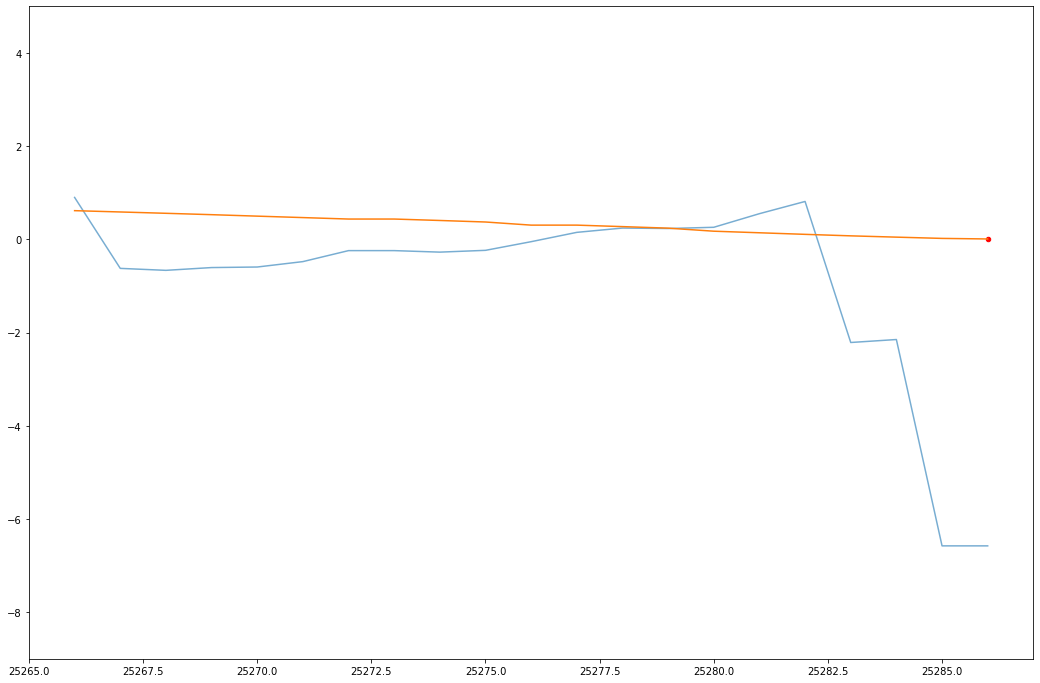

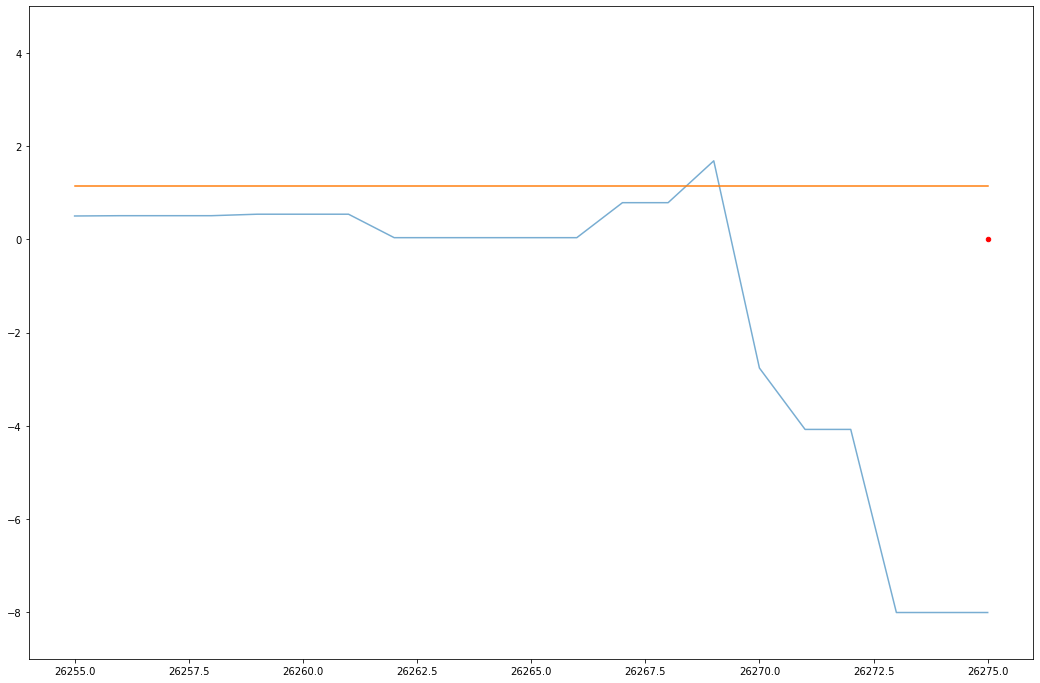

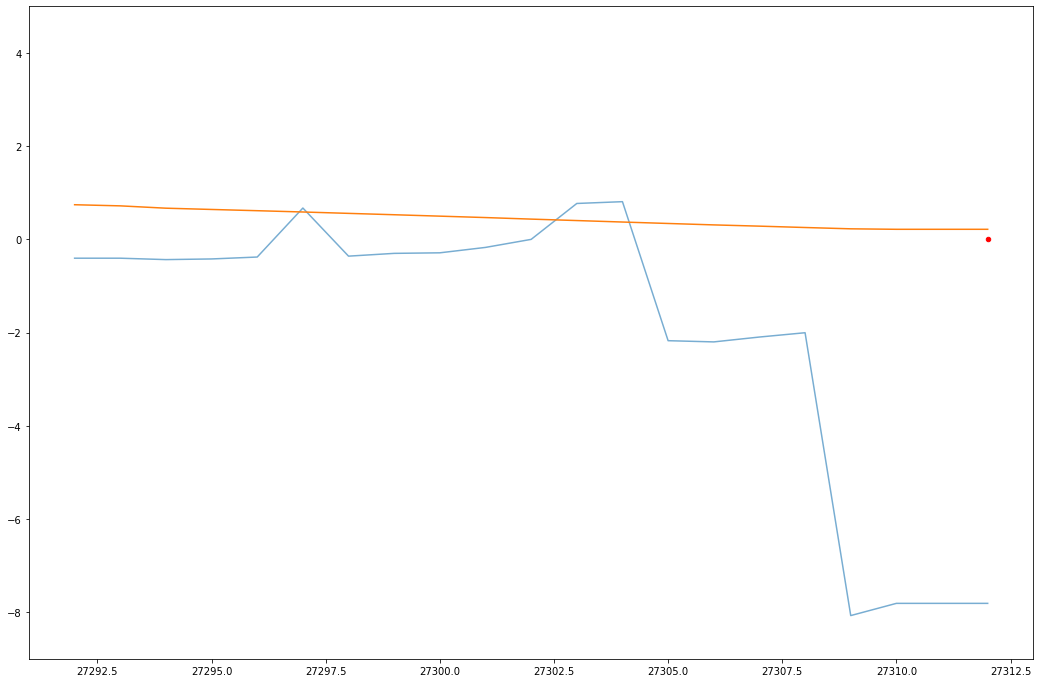

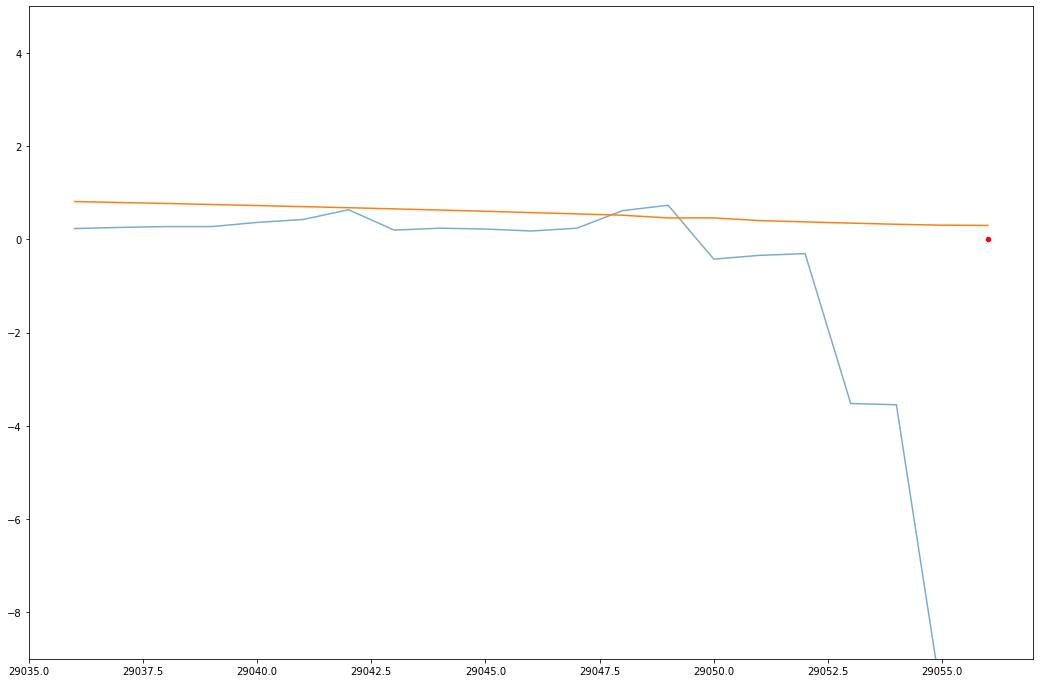

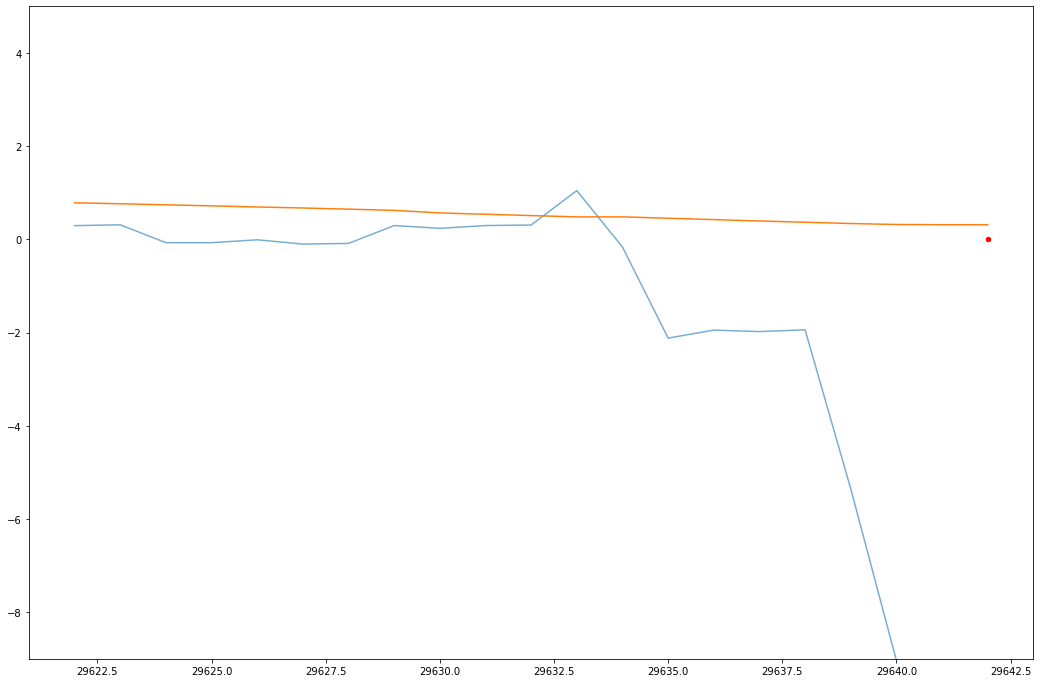

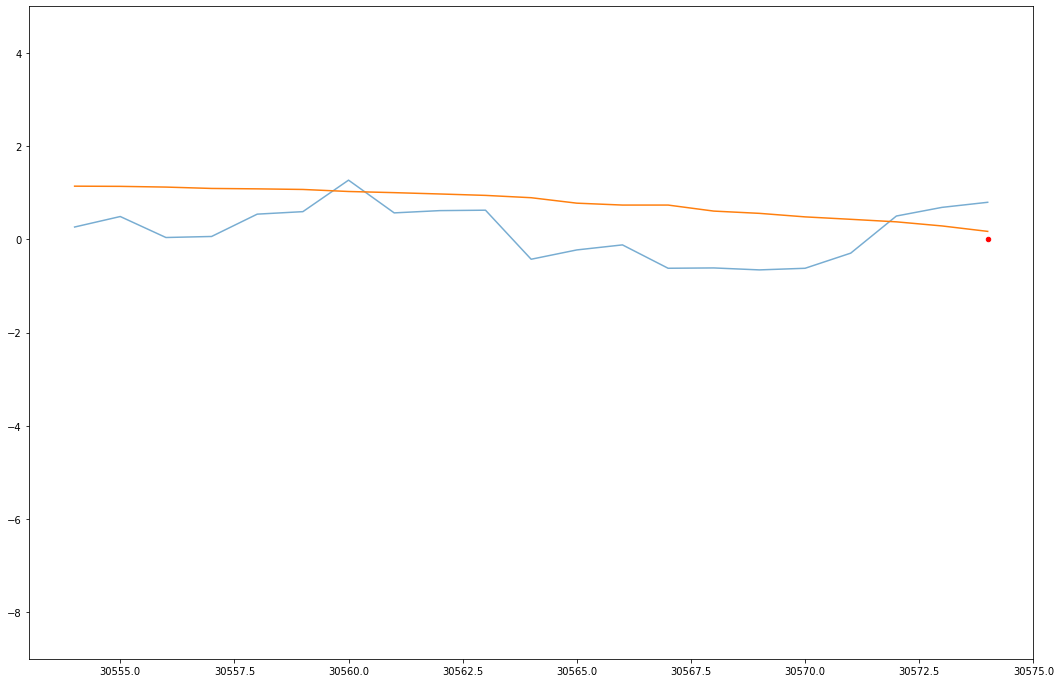

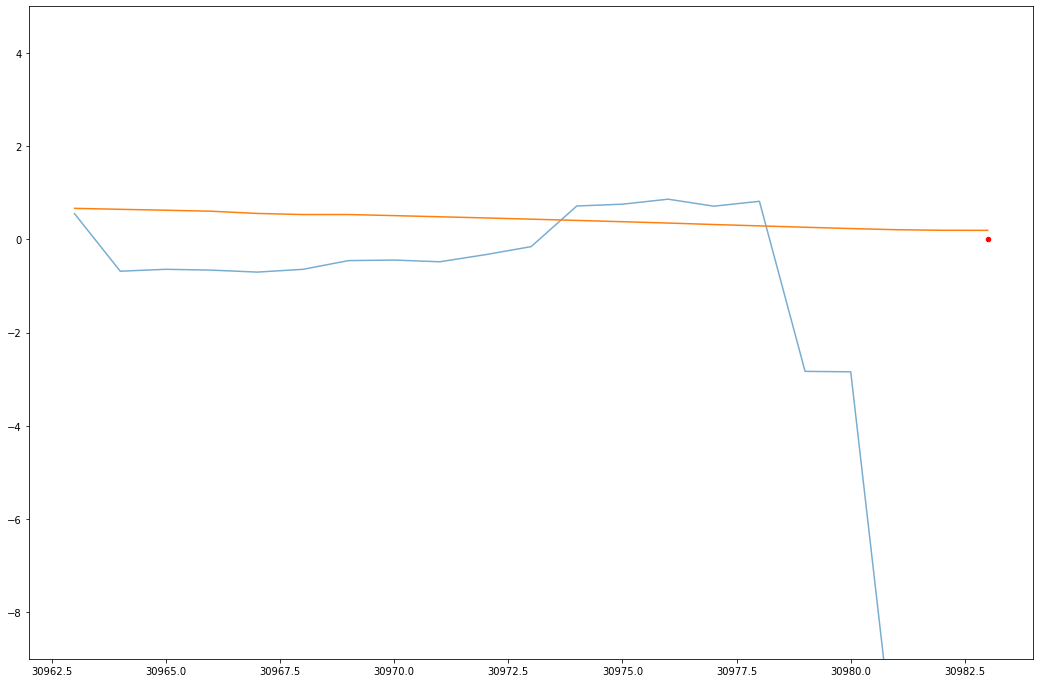

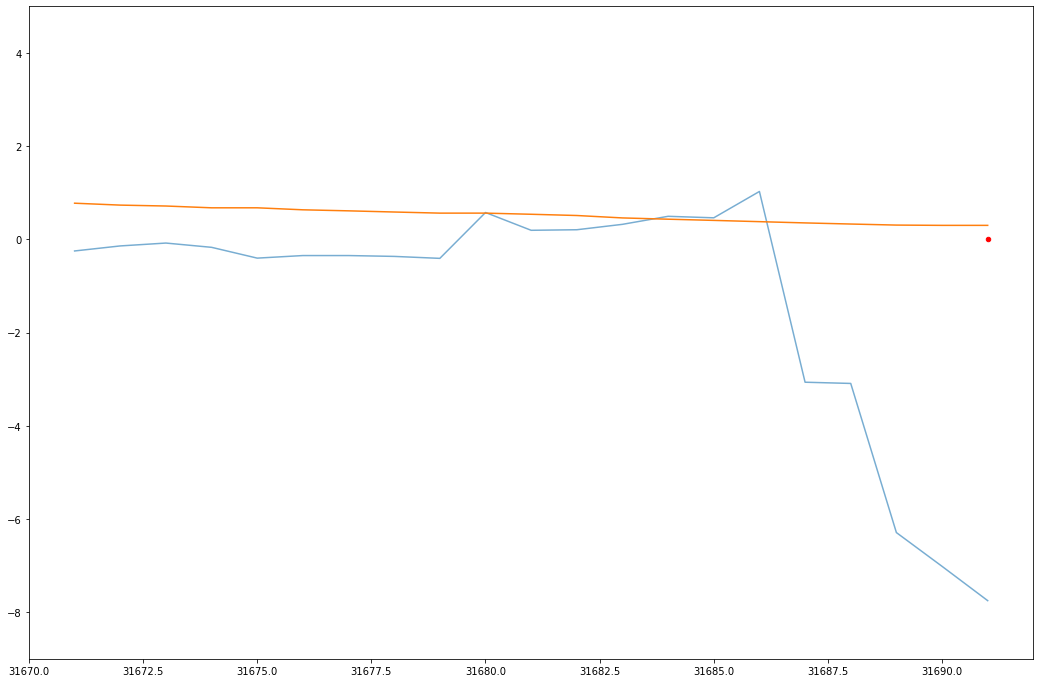

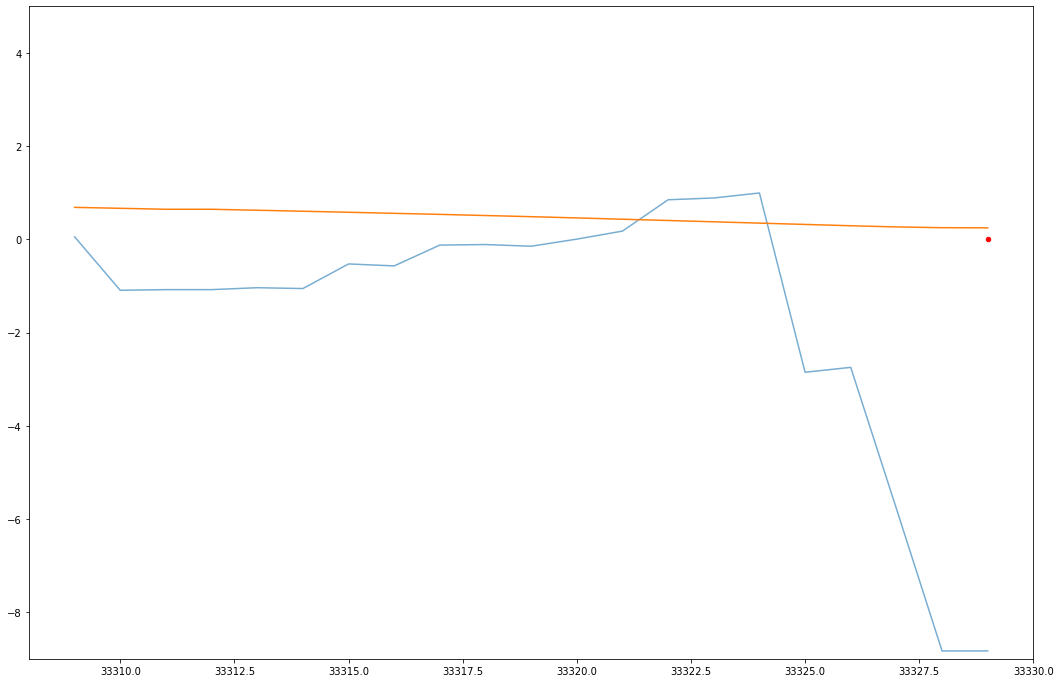

In [56]:
plot_only_faults(df, feature)

## Data and constants storage

In [57]:
df.to_csv("data/train/training_" + str(margin) + ".csv")

with open('data/utils/scaler_' + str(margin) + '.bin', 'wb') as handle:
    pickle.dump(scaler, handle)
with open('data/utils/fixed_orient_' + str(margin) + '.bin', 'wb') as handle:
    pickle.dump(fixed_orient, handle)
with open('data/utils/fixed_pos_' + str(margin) + '.bin', 'wb') as handle:
    pickle.dump(fixed_pos, handle)
with open('data/utils/differencing_dict_' + str(margin) + '.bin', 'wb') as handle:
    pickle.dump(differencing_dict, handle) 